# 4th Homework of ADM

### Group members

#### 1. Mehrdad Hassanzadeh, 1961575, hassanzadeh.1961575@studenti.uniroma1.it
#### 2. Letizia Russo, 1869768, russo.1869768@studenti.uniroma1.it
#### 3. Irene Aguanno, 1835679, aguanno.1835679@studenti.uniroma1.it


# Importing useful packages

In [8]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
from sympy import nextprime
from random import randint
import pandas as pd
from collections import defaultdict
from sklearn.utils import shuffle
from itertools import combinations 

# 0. Required Functions

Here we have some provided functions that will help us to convert .mp3 files to .wav files and also help us to find the peaks in each song. 

## 0.1 Utility functions

In [9]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
            peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

## 0.2 Settings

Here we will fix some of the settings in order to convert our .mp3 file to .wav files. 

In [10]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = .1 # TODO: to be tuned!

We want to convert the .mp3 files that exist in 'data' directory to .wav files. 

In [13]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## 0.3 Preprocessing

We will convert the given .mp3 files to .wav files. 

In [12]:
for track in tqdm(mp3_tracks, total = N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

# 1. Implementing your own Shazam

Here we are asked given some query songs, find the songs among all the songs that we have in our dataset. 

The metric that we use in order to identify a songs is the 'peaks' contained in each song. 

**The very first step is to take the peaks of each of the songs that we have in our dataset**

## 1.1 Peak extraction

We will take the peaks in each songs in our dataset and store them in a dataframe. 

In [14]:
# The dataFrame to store the songs and their peaks.
# We define a peak as a (time, frequency) pair
# corresponding to an amplitude value which is the greatest in a local “neighborhood” around it.
df = pd.DataFrame(columns = ['Song', 'Peaks']) 

# For each song, we will store its peaks in to the dataframe
for idx, audio in enumerate(tracks):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    df = df.append({'Song':audio, 'Peaks':peaks}, ignore_index = True)

You can see some examples of the information that we are storing in our dataframe. 

'Song' column will store the name and path of each song and 'Peaks' will store an array for each song which consists the index of the peaks in that song.

In [15]:
df

,Song,Peaks
0,data/mp3s-32k/queen/Jazz/04-Bicycle_Race.wav,"[15, 45, 85, 107, 139, 154, 169, 182, 199, 214..."
1,data/mp3s-32k/queen/Jazz/09-Dreamers_Ball.wav,"[7, 25, 39, 60, 103, 126, 140, 158, 172, 192, ..."
2,data/mp3s-32k/queen/Jazz/07-Dead_On_Time.wav,"[119, 160, 274, 324, 436, 474, 489, 525, 539, ..."
3,data/mp3s-32k/queen/Jazz/13-More_Of_That_Jazz.wav,"[13, 29, 45, 57, 74, 88, 110, 131, 146, 175, 1..."
4,data/mp3s-32k/queen/Jazz/03-Jealousy.wav,"[6, 20, 36, 51, 66, 82, 97, 113, 129, 161, 176..."
...,...,...
1408,data/mp3s-32k/beatles/Abbey_Road/10-Sun_King.wav,"[8, 28, 49, 63, 81, 97, 114, 132, 148, 165, 20..."
1409,data/mp3s-32k/beatles/Abbey_Road/11-Mean_Mr_Mu...,"[3, 24, 40, 54, 69, 82, 96, 109, 123, 137, 151..."
1410,data/mp3s-32k/beatles/Abbey_Road/02-Something.wav,"[21, 42, 62, 84, 103, 145, 169, 187, 229, 251,..."
1411,data/mp3s-32k/beatles/Abbey_Road/09-You_Never_...,"[6, 20, 36, 53, 69, 84, 100, 117, 132, 147, 17..."


* **Note:** We want to remind that for extracting the similar songs given some songs, we have used 2 different approaches.<br/>
1. Using just Minhash 
2. Using LSH and Minhash combined


## 1.2 Query answering

Our first approach to do this process in using just Minhash algorithm. 

###  1.2.1 Minhash

If we want to be able to find the similar songs using Minhash function we should take these steps: 

1. Define a hash function 
2. Produce a hash list (more info later)
3. Consider the first k values of the hash list 
4. Computer the similarity between two hash list. 
5. Show the result of the similar song for each query 

### 1.2.1.1 Hashing

Usually when we want to define a hash function to map some numbers to different values, we use this function:<br/>
h(x) = ax + b % w <br/>

**x:** the given number<br/>
**a, b:** random generated numbers <br/>
**w:** the next prime number from the number of the values we want to hash 


Here we know that we want to map each peak to another values, so we need to know how many different values we have in our data. In our case we take the 'maximum peak' (MaxPeak) as the number of different peaks we want to hash.<br/> <br/>
**So in our case, 'w' will be the next prime from 'MaxPeak' value.**

In [16]:
# We take the maximum value among the "Peaks" column of the dataframe
MaximumValue = df['Peaks'].apply(lambda x: max(x)).max()

# In order to apply the Hash function, we must find the values of w, a and b.
# We can get "w" as the next prime number for the given maximum value
# Also we need two random values a, b
w, a, b = nextprime(MaximumValue), randint(1, 500), randint(1, 500) 

# Check the values of the hash parameters
print('Maximum value among peaks: ', MaximumValue)
print('Value of \'w\': ', w)
print('Value of \'a\': ', a)
print('Value of \'b\': ', b)

Maximum value among peaks:  1291
Value of 'w':  1297
Value of 'a':  377
Value of 'b':  264


### 1.2.1.2 Hash function 

This function given a number and hash function parameters, will hash the value and return the result. 

In [17]:
# We apply the definition of Hash Function.
# A hash function takes an integer input and returns another integer as output.

def Hash(Number, a, b, w):
    return (a * Number + b) % w

### 1.2.1.3 HashList function

This function given a list of integers, will produce another list which in some sense will be the buckets of our hash functions. <br/>
1. The default value of our buckets will be 0.  
2. After hashing an integer in the list we will put 1 to the value of that list. 

In [20]:
def HashList(ListOfElements, a, b, w):
    
    # Produce our buckets initialized with 0
    HashedList = [0] * w
    
    # Going through each number in the list
    for Number in ListOfElements:
        
        # We will put 1 into the bucket of the returned value after hashing the current number
        HashedList[Hash(Number, a, b, w)] = 1
        
    return HashedList

For each peak list of the songs, we will produce a hashlist for them and store them as another column in our dataframe. 

In [66]:
# We add a new column into our dataframe that contains all the Hashed values obtained
# Applying the HashList function in correspondence of each song's Peaks list.
df['Hashed'] = df['Peaks'].apply(lambda x: HashList(x, a, b, w))
df

,Song,Peaks,Hashed
0,queen/Jazz/04-Bicycle_Race.wav,"[15, 45, 85, 107, 139, 154, 169, 182, 199, 214...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,queen/Jazz/09-Dreamers_Ball.wav,"[7, 25, 39, 60, 103, 126, 140, 158, 172, 192, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,queen/Jazz/07-Dead_On_Time.wav,"[119, 160, 274, 324, 436, 474, 489, 525, 539, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,queen/Jazz/13-More_Of_That_Jazz.wav,"[13, 29, 45, 57, 74, 88, 110, 131, 146, 175, 1...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,queen/Jazz/03-Jealousy.wav,"[6, 20, 36, 51, 66, 82, 97, 113, 129, 161, 176...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1408,beatles/Abbey_Road/10-Sun_King.wav,"[8, 28, 49, 63, 81, 97, 114, 132, 148, 165, 20...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1409,beatles/Abbey_Road/11-Mean_Mr_Mustard.wav,"[3, 24, 40, 54, 69, 82, 96, 109, 123, 137, 151...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1410,beatles/Abbey_Road/02-Something.wav,"[21, 42, 62, 84, 103, 145, 169, 187, 229, 251,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1411,beatles/Abbey_Road/09-You_Never_Give_Me_Your_M...,"[6, 20, 36, 53, 69, 84, 100, 117, 132, 147, 17...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


You can see in the result above, if we have 1 in hashlist of a songs, means that we had that hash value after applying the hash function on the values in the peaks of the songs. 

### 1.2.1.4 MinHashSimilarity function 

When we want to compute similarity between hash list which can be considered as the similarity between two sets, we take the first k elements in the two sets combined. Then we will use Jaccard similarity formula to compute the similarity between two sets. <br/><br/>
**Jaccard Similarity(A,B): #Elements in intersection(A,B) / (#Elements in union(A,B)**

In Jaccard Similarity we consider the sets that have significantly large intersection as similar sets. 

In [22]:
# Given two sets and k we will check the similarity on the first k
# elements in these two sets. 

def MinHashToSimilarity(List1, List2, k = 200):
    
    
    # Here we definde two sets to store the elements in the two sets and also the union
    # of these two sets
    Set1, Set2 = set(), set() 
    SetUnion = set()
    
    # We go through the hashlist of these two sets
    # and for each element in the set
    for HashIndex in range(len(List1)):
        
        # If the current element exists in the first set
        # we will add this element to the set for the first
        # and also to the union set of these two 
        if List1[HashIndex]:
            Set1.add(HashIndex)
            SetUnion.add(HashIndex)
            
        # If the current element exists in the second set
        # we will add this element to the set for the second
        # and also to the union set of these two 
        if List2[HashIndex]:
            Set2.add(HashIndex)
            SetUnion.add(HashIndex)
            
        # If we got our k element we received the needed element
        # and we are ready to compute the similarity between these two sets
        if len(SetUnion) == k:
            break
            
    # Computing the similarity by applying the Jaccard Similarity 
    # Number of the elements in the intersection by the number of 
    # the element in the union of these two sets. 
    Similarity = len(Set1.intersection(Set2))/len(SetUnion)
    
    return Similarity

### 1.2.1.5 Query processing 


Now we are ready to anwer to the queries. 

We should follow the same steps that we took for the original dataset. <br/>
1. We will take the peaks of each query 
2. Apply the same hash function on the peaks of each element to produce the hash list

In [74]:
# Once we've crated another dataframe in order to consider just the queries requested,
# we insert into it the information we need, such as the audio and the peaks, again.
QueryDf, Path = pd.DataFrame(columns = ['Song', 'Peaks']), 'Queries/track'

# As we know that we have 10 different queries, we will go through them 
for QueryIndex in range(1, 11) :
    
    # First we will create the path for each of the query songs
    audio = Path+str(QueryIndex)+'.wav'
    
    # We will take the peak of each query song
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    
    # Add the name of the query and also the list of the peak for that song to 
    # the dataframe
    QueryDf = QueryDf.append({'Song':audio, 'Peaks':peaks}, ignore_index = True)
    
QueryDf
# You can check the result below.Not suprisingly we have 10 rows (number of the queries) and 2 columns

,Song,Peaks
0,Queries/track1.wav,"[7, 24, 40, 57, 73, 89, 107, 124, 140, 156, 17..."
1,Queries/track2.wav,"[9, 21, 33, 45, 57, 68, 81, 92, 104, 116, 128,..."
2,Queries/track3.wav,"[13, 30, 102, 133, 150, 223, 253, 269, 341, 37..."
3,Queries/track4.wav,"[10, 21, 32, 43, 56, 67, 80, 90, 102, 114, 126..."
4,Queries/track5.wav,"[6, 41, 60, 76, 111, 147, 167, 182, 218, 235, ..."
5,Queries/track6.wav,"[30, 57, 85, 112, 142, 169, 192, 206, 225, 254..."
6,Queries/track7.wav,"[6, 24, 53, 72, 101, 120, 140, 160, 178, 196, ..."
7,Queries/track8.wav,"[9, 24, 37, 58, 71, 86, 99, 127, 155, 183, 211..."
8,Queries/track9.wav,"[12, 404, 663, 675, 691, 752, 931, 979, 1006, ..."
9,Queries/track10.wav,"[9, 28, 41, 54, 67, 87, 107, 119, 167, 187, 20..."


Then we are ready to create the hashlist of the peaks of each song. 

In [75]:
# Again we compute the Hash in order to obatin the third column, the "Hashed" one, 
# containing all the hashed list applying the HashList function in correspondence of each song's Peaks list.
QueryDf['Hashed'] = QueryDf['Peaks'].apply(lambda x: HashList(x, a, b, w))
QueryDf

,Song,Peaks,Hashed
0,Queries/track1.wav,"[7, 24, 40, 57, 73, 89, 107, 124, 140, 156, 17...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Queries/track2.wav,"[9, 21, 33, 45, 57, 68, 81, 92, 104, 116, 128,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,Queries/track3.wav,"[13, 30, 102, 133, 150, 223, 253, 269, 341, 37...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Queries/track4.wav,"[10, 21, 32, 43, 56, 67, 80, 90, 102, 114, 126...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Queries/track5.wav,"[6, 41, 60, 76, 111, 147, 167, 182, 218, 235, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Queries/track6.wav,"[30, 57, 85, 112, 142, 169, 192, 206, 225, 254...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
6,Queries/track7.wav,"[6, 24, 53, 72, 101, 120, 140, 160, 178, 196, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Queries/track8.wav,"[9, 24, 37, 58, 71, 86, 99, 127, 155, 183, 211...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Queries/track9.wav,"[12, 404, 663, 675, 691, 752, 931, 979, 1006, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Queries/track10.wav,"[9, 28, 41, 54, 67, 87, 107, 119, 167, 187, 20...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 1.2.1.6 Main function

Now we are ready to answer the queries, given the queries and the original dataset. <br/>
The parameters of this function are: <br/><br/>
1. **Dataset:** the original songs that we have in the dataset. 
2. **Querids:** the queries that we want to find them in the dataset
3. **Threshold:** a lower bound for the similarity between the query and the original songs in the dataset. 
4. **KOFMinHash:** how many elements we want to consider in the hash list to compute the similarity between the two songs

In [76]:
def QueryToSimilarSong(Dataset, Queries, Threshold, KOfMinHash):
    
    # We store the results in a dictionary named 'Result'(this will be a multiIndexed dictionary)
    # keys: (query, similar song)
    # values: the similarity between the query and a specific song
    Result = {}
    
    Answers = pd.DataFrame(columns = ['QuerySong', 'SimilarSongs', 'Similarity'])
    
    # We will through each query in the dataframe
    for QueryIndex in range(len(Queries)):
        
        # First We will store the resulted songs for this query song in a dictionary
        # keys: Song in the dataset
        # values: The similarity between the query song and a song in the dataset
        DictAnswer = {}
        
        # We take the hash list of the current query
        HashedQuery = Queries.iloc[QueryIndex]['Hashed']
        
        # We go through the songs in the dataset
        for SongsIndex in range(len(Dataset)):
            
            # We take the hash list of the current song in the dataset
            HashedSong = Dataset.iloc[SongsIndex]['Hashed']
            
            # We compute the similarity between these two songs
            Similarity = MinHashToSimilarity(HashedQuery, HashedSong, KOfMinHash)
            
            # If their similarity was greater than the threshold
            if  Similarity > Threshold:
                                
                # It's useful to take just the name of the songs and authors name and remove the path.
                SongName = "/".join(str(Dataset.iloc[SongsIndex]['Song']).split('/')[2:]).replace('.wav', '')
                
                # We will put the similarity of this song with respect to the query song in
                # the dictionary
                DictAnswer[SongName] = Similarity
        # We will sort the similar songs based on the their similarity with the current query song
        DictAnswer = {i[0]:i[1] for i in sorted(DictAnswer.items(), key = lambda x:x[1], reverse = True)}
        
        # Here we will put the similar songs in the answer dataframe
        for index, Ans in enumerate(DictAnswer):
            
            # We store for each query and the songs, their similarity in the dictionary
            Result[(Queries.iloc[QueryIndex]['Song'], Ans)] = DictAnswer[Ans]
    
    # Showing the results in a multiIndexed dataframe
    ResultDf = pd.Series(Result).to_frame("Similarity")
    display(ResultDf)

Here we call the function above given the original dataset and the queries. We put the threshold to .1 and we will consider the first 200 elements in order to check the similarity between two songs. 

In [77]:
# Dataset, Query, Threshold, K of MinHash
QueryToSimilarSong(df, QueryDf, .1, 200)

Similarity
Queries/track1.wav  03-Dream_On                 1.000000
Queries/track2.wav  06-I_Want_To_Break_Free     1.000000
                    04-Walk_This_Way            0.116564
Queries/track3.wav  07-October                  1.000000
Queries/track4.wav  04-Ob-La-Di_Ob-La-Da        1.000000
                    02-Lie_To_Me                0.207865
                    02-Love_Is_Dangerous        0.134146
                    02-Bad_Sneakers             0.130435
                    07-Ants_Marching            0.118750
                    09-Penny_Lane               0.101351
Queries/track5.wav  06-Karma_Police             1.000000
Queries/track6.wav  05-Heartbreaker             1.000000
                    03-I_Wonder_U               0.114504
                    13-Tight_Wad_Hill           0.104000
Queries/track7.wav  05-Go_Your_Own_Way          1.000000
Queries/track8.wav  01-American_Idiot           1.000000
                    02-Fly_on_the_windscreen    0.121951
                    11-Damn_U                   0.110169
Queries/track9.wav  06-Somebody                 1.000000
Queries/track10.wav 01-Black_Friday             1.000000

# 1.2.2 LSH and Minhash

In the second approach we are using the combination of LSH and Minhash algorithms. In order to be able to answer the queries by using this approach we should take these steps: <br/><br/>
1. Extract the peaks of each song in the dataset
2. Creating a dataframe to show which peak is in which song (rows: peaks, columns: songs)
3. Creating signature matrix for the information by considering different permutations
4. Divide the signature matrix based on the band size and hash each band with different hash function
5. Put the songs that will be assigned to the same bucket at each band 
6. Given a query do the same process with the same permutations
7. Check the similarity between the query and the songs by checking the buckets they share
8. Show the result 

Here first we will choose the number of the bandsize and the number of permutations we need in order to produce the signature matrix. 

In [27]:
# What is the band size when applying min hash. 
BandSize = 2

# How many permutations we will produece
NumOfPermutation  = 200 # it should be divisible by the BandSize 

## 1.2.2.1 Reading the dataset 

Here we will use the same dataset. You can see the peaks of each song below. 

In [35]:
df = df.drop('Hashed', axis = 1)
df

,Song,Peaks
0,queen/Jazz/04-Bicycle_Race.wav,"[15, 45, 85, 107, 139, 154, 169, 182, 199, 214..."
1,queen/Jazz/09-Dreamers_Ball.wav,"[7, 25, 39, 60, 103, 126, 140, 158, 172, 192, ..."
2,queen/Jazz/07-Dead_On_Time.wav,"[119, 160, 274, 324, 436, 474, 489, 525, 539, ..."
3,queen/Jazz/13-More_Of_That_Jazz.wav,"[13, 29, 45, 57, 74, 88, 110, 131, 146, 175, 1..."
4,queen/Jazz/03-Jealousy.wav,"[6, 20, 36, 51, 66, 82, 97, 113, 129, 161, 176..."
...,...,...
1408,beatles/Abbey_Road/10-Sun_King.wav,"[8, 28, 49, 63, 81, 97, 114, 132, 148, 165, 20..."
1409,beatles/Abbey_Road/11-Mean_Mr_Mustard.wav,"[3, 24, 40, 54, 69, 82, 96, 109, 123, 137, 151..."
1410,beatles/Abbey_Road/02-Something.wav,"[21, 42, 62, 84, 103, 145, 169, 187, 229, 251,..."
1411,beatles/Abbey_Road/09-You_Never_Give_Me_Your_M...,"[6, 20, 36, 53, 69, 84, 100, 117, 132, 147, 17..."


Here for a better visualization of the name of the songs, we will remove the first part of their information. 

In [36]:
# We clear the visualization of the song removing from its name the path information.
df['Song'] = df['Song'].apply(lambda x: str(x).replace('data/mp3s-32k/', ''))

In [37]:
df

,Song,Peaks
0,queen/Jazz/04-Bicycle_Race.wav,"[15, 45, 85, 107, 139, 154, 169, 182, 199, 214..."
1,queen/Jazz/09-Dreamers_Ball.wav,"[7, 25, 39, 60, 103, 126, 140, 158, 172, 192, ..."
2,queen/Jazz/07-Dead_On_Time.wav,"[119, 160, 274, 324, 436, 474, 489, 525, 539, ..."
3,queen/Jazz/13-More_Of_That_Jazz.wav,"[13, 29, 45, 57, 74, 88, 110, 131, 146, 175, 1..."
4,queen/Jazz/03-Jealousy.wav,"[6, 20, 36, 51, 66, 82, 97, 113, 129, 161, 176..."
...,...,...
1408,beatles/Abbey_Road/10-Sun_King.wav,"[8, 28, 49, 63, 81, 97, 114, 132, 148, 165, 20..."
1409,beatles/Abbey_Road/11-Mean_Mr_Mustard.wav,"[3, 24, 40, 54, 69, 82, 96, 109, 123, 137, 151..."
1410,beatles/Abbey_Road/02-Something.wav,"[21, 42, 62, 84, 103, 145, 169, 187, 229, 251,..."
1411,beatles/Abbey_Road/09-You_Never_Give_Me_Your_M...,"[6, 20, 36, 53, 69, 84, 100, 117, 132, 147, 17..."


## 1.2.2.2 Which peak in which songs? 

Here we should create a dataframe that shows for each peak if that peak is contained in which songs. 

We know that we have 1413 songs, so for each of the peaks we should store a list of size 1413 which consists 0s and 1s. '1' means that that specific peak is contained in that song otherwise '0'. 

To get rid of the name of the each song, we will give to each song a numebr. In this case we will reduce the required memory for the dataframe as well. 

In [38]:
# A dictionary which give to each song a unique index. 
# keys: The index assigned to a song
# values: The name of the song
DictIndexToName = {Index:Song for Index, Song in enumerate(df['Song'])}

- Now we will try to produce the mentioned dataframe. 

In [40]:
# We will store these information in a dictionary. 
# Keys: The peaks
# Values: A list of size the songs in the dataset. We put 1 where that corresponded song
# was containing that specific peak 
# By default this list will be a list of 0s for each peak
DictPeakToDoc = defaultdict(lambda: [0]*len(df))

# Now we will take the peaks for each of the songs and go through them
for SongIndex, SongPeaks in enumerate(df['Peaks']):
    
    # Going through the peaks in the current song
    for Peak in SongPeaks:
        
        # Place 1 for in the list of that peak for that song index, which mean that 
        # that song was cointaning that peak 
        DictPeakToDoc[Peak][SongIndex] = 1

Having the mentioned dictionary, we are ready to show the dataframe. 

In [41]:
# DataFrame contains the information about each peak and the songs
PeakDocDF = pd.DataFrame(columns = [*list(range(1413))])

# We will go through each peak in all the songs
for peak in DictPeakToDoc:
    
    # We take the list of that peak and add it to the dataframe
    PeakDocDF.loc[peak] = DictPeakToDoc[peak]

# We sort the dataframe based on the value of each peak
PeakDocDF.sort_index(inplace = True)

# Showing the dataframe
PeakDocDF

,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1288,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1289,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1290,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


To make sure that this dataframe was produced in the correct way we should take a look at it. 

In [42]:
# Take the first 20 rows of this dataframe
PeakDocDF.head(20)

,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For example here we can see that: <br/><br/>
1. 1st song should contain the peak 15 and in the 15th row we can see the value of the 1st column is 1. 
2. 7th song should contain the peak 7 and in the 7th row we can see the value of the 2nd column is 1. 

## 1.2.2.3 Signature matrix

Now having this information, we should permute this dataframe and for each permutation produce its signature and add it to the signature matrix. 

**What is signature?**<br/>
In each permutation, the signature of that permutation is a list which representes the index of the first appearance of 1 in each of the columns. 

In [43]:
# We take a copy of the dataframe
ForPermutationDF = PeakDocDF.copy()

**What are the steps to produce the signature matrix:**
1. Permute the dataframe based on the number of requested permuations. <br/>
2. Produce the signature of that permutation and add it to another dataframe.<br/>
3. After performing all the permutations and adding their signatures to the dataframe we have the signature matrix


In [44]:
# Here we will store our signature matrix in 'SignatureDataFrame' dataframe. 

# Also in order to be able to apply the same order of the rows for each permutations 
# we will keep track of the order of the rows for each permutation and store them in
# 'PeakPermutation' list. 
SignatureDataFrame, PeakPermutation = pd.DataFrame(columns = [*list(range(1413))]), []

# Now we permute the dataframe based on the number of requested number of permutations
for _ in range(NumOfPermutation):
    
    # We shuffle the dataframe to have a new permutation
    ForPermutationDF = shuffle(ForPermutationDF)
    
    # We add the order of the peaks in the dataframe to the list
    PeakPermutation.append(list(ForPermutationDF.index))
    
    # In order to compute the signature of this permutation we should store the 
    # index of the first appearance of 1 in each column. 
    # This information will be store in this list for each permutation. 
    FirtOneOccurance = []
    
    # We go throgh each of the columns
    for col in ForPermutationDF.columns:
        
        # Take the index of the first appearance of '1' for that column and add it
        # to the list
        FirtOneOccurance.append(list(ForPermutationDF[col].values).index(1)+1) 
    
    # Now we have the signature for this permutation so we will add it to the signature matrix(dataframe)
    SignatureDataFrame.loc[_] = FirtOneOccurance

# We should the values stored in the signature matrix
print('Signature Matrix: ')
display(SignatureDataFrame)

# Order of the peaks for the first permutation
print('Peak in order to make signature: ', PeakPermutation[0])

Signature Matrix: 


,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
0,22,7,44,30,15,2,8,24,19,3,...,2,1,31,23,8,15,1,19,7,15
1,30,4,64,14,19,7,2,12,10,6,...,12,17,29,42,11,3,10,46,7,2
2,1,19,56,24,1,4,22,1,39,1,...,5,22,8,8,3,99,32,2,14,17
3,43,17,100,16,66,2,9,3,27,22,...,52,5,14,26,11,22,5,3,4,35
4,25,17,24,17,9,22,24,18,8,25,...,2,2,7,49,16,21,2,13,57,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,14,39,27,2,13,3,4,36,2,29,...,5,3,12,2,38,29,11,6,16,9
196,15,18,35,13,21,32,4,19,45,23,...,67,26,18,8,24,17,39,9,1,8
197,6,5,21,12,29,5,1,8,6,2,...,16,2,3,5,2,7,10,10,16,29
198,40,21,17,24,5,10,4,21,98,14,...,2,6,6,32,6,2,3,48,5,24


Peak in order to make signature:  [792, 183, 616, 624, 760, 741, 1193, 108, 735, 220, 851, 1048, 812, 869, 878, 567, 1001, 864, 62, 965, 904, 1178, 1186, 138, 234, 235, 674, 598, 548, 723, 521, 1212, 930, 891, 483, 65, 396, 537, 1173, 1168, 213, 1018, 152, 751, 192, 743, 378, 645, 35, 724, 176, 823, 781, 630, 1134, 775, 810, 582, 755, 1116, 338, 644, 961, 207, 752, 372, 156, 773, 368, 991, 1037, 539, 1004, 25, 981, 613, 1259, 990, 1208, 105, 1278, 1270, 384, 888, 365, 786, 438, 225, 75, 1150, 1123, 161, 905, 481, 24, 269, 686, 677, 109, 186, 611, 1082, 908, 1087, 1184, 1107, 641, 1038, 631, 1103, 712, 193, 377, 855, 1064, 308, 259, 1260, 300, 780, 1130, 485, 1094, 491, 334, 264, 209, 110, 15, 113, 948, 177, 950, 165, 373, 8, 997, 467, 887, 707, 844, 446, 579, 1044, 909, 571, 837, 511, 383, 817, 1022, 1100, 478, 957, 933, 1034, 330, 236, 612, 1098, 604, 1012, 287, 59, 1000, 803, 230, 263, 551, 173, 448, 1091, 842, 860, 404, 413, 1147, 807, 670, 805, 10, 139, 726, 267, 699, 1166, 1011, 1

## 1.2.2.4 Hashing Signatures

**What are the steps to hash the signatures?**
1. We divide the signatures based on the band size
2. We produce new hash function for each band
3. For each column we will hash the values in that columns
4. Put that column in the corresponded bucket.

## Important note

We know that for each band, we should store the songs that were assigned to the buckets using the hash function for that band. Also we need the parameters used for the hash function at that band. 

In order to store all of these information we created a data structure in this format: <br/><br/>
1. First level Dictionary (stores the information for each band):<br/>
**Keys:** The index of the band<br/>
**Values:** A list of two elements. [<font color='green'>Second level dictionary</font>, (parameters of the hash function in this band)<br/>

2. <font color='green'>Second level dictionary</font> (stores the information of the buckets:<br/>
**Keys:** The value of the bucket<br/>
**Values:** A list of the songs that were assigned to this bucket

## 1.2.2.4.1 HashSignature function

As we know we considered the band size equal to '2', then we now for hashing each columns' values we need a hash function that given two numbers produce 1 output. <br/><br/>
So here our hash function will be:<br/>
h(x,y) = ax + by % w <br/><br/>
**x,y:** two given numbers that should be hashed<br/>
**a,b:** random numbers as coefficients<br/>
**w:** the next prime number from the number of the values we want to hash 


In [45]:
# Given a list of two numbers and the parameters produce the hash of those
def HashSignature(Numbers, a, b, w):
    return (a*Numbers[0] + b*Numbers[1]) % w

## 1.2.2.4.2 StoreHashedInfo function 

In this function for each column that should be hashed, given the values of a column we will hash the column by using the parameters of the hash function in this band and also add the name of the column to the corresponded bucket in the given band. 

In [46]:
# Hashed the values of the columns given:
# The storage where stores all the informations for each band (BucketDictinary)
# The index of the current band  (BandIndex)
# The columns itself (Column)
# The parameters of the hash function (a, b, w)
def StoreHashedInfo(BucketDictionary, BandIndex, Column, a, b, w):
    
    # We will hash the values in the column 
    Hash = HashSignature(Column.to_list(), a, b, w)
    
    # Then we will add the namd oe the column to the correct bucket in the given band 
    BucketDictionary[BandIndex][0][Hash].append(Column.name)
    
    # We will return the produce hash              
    return Hash

## 1.2.2.4.3 Main of the hashing process

Here for each band, we will hash the columns in that band and store the information in our dictionary. 

In [47]:
# We will store which bucket was assigned to each column in each of the bands
HashedSignaturesDataFrame = pd.DataFrame(columns = [*list(range(1413))])

# This is the dictionary that we will store all the necessary information for 
# each band, bucket values and the parameters of each hash function for that specific band
BucketDictionary = defaultdict(lambda: [defaultdict(list), []])

# We go through each band 
for BandIndex in range(NumOfPermutation//BandSize):
    
    # Take the part of the information that is contanined in this band 
    # In our example as we considered the band size as 2 for the first band
    # we will consider the first two rows of the signature matrix 
    SignaturesInBand = SignatureDataFrame.iloc[BandIndex*BandSize:BandIndex*BandSize+BandSize]
    
    # We will generate the parameters for the hash function of this band 
    w, a, b = nextprime(len(ForPermutationDF.columns)), randint(1, 500), randint(1, 500)
    
    # We add the parameters of the hash function of this band to the dictionary
    BucketDictionary[BandIndex][1] += [a, b, w]
    
    # Now we will hash the information in this band and return the 
    # bucket for each column 
    HashedSignaturesDataFrame.loc[BandIndex] = SignaturesInBand.apply(
        lambda x: StoreHashedInfo(BucketDictionary,BandIndex, x, a, b, w))

In [48]:
# You can check which was assigned to each column in each band
HashedSignaturesDataFrame

,0,1,2,3,4,5,6,7,8,9,...,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412
0,1057,1380,708,1327,3,470,1058,1065,1201,508,...,847,826,10,83,29,1358,1152,1354,1037,998
1,748,440,932,860,838,1275,1158,344,1123,109,...,813,833,1228,780,483,684,1124,800,1017,279
2,1215,1032,164,46,442,1390,601,940,1001,692,...,903,944,753,729,448,242,268,780,826,1087
3,567,231,195,1082,300,565,579,453,338,56,...,693,1222,494,105,1372,848,569,1129,158,1153
4,1152,1288,177,384,812,1054,664,182,1271,1288,...,702,1010,744,158,160,437,561,533,911,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,840,189,259,585,303,1239,811,671,1163,276,...,665,917,181,227,830,1204,1232,27,714,954
96,408,13,12,841,1237,1008,1135,1304,1262,1303,...,1285,647,1049,72,389,334,393,1355,862,368
97,1081,333,1246,794,596,1199,469,861,43,872,...,490,1279,255,651,440,1000,1369,368,660,575
98,1258,1118,861,1352,1159,821,703,716,215,173,...,1325,211,762,517,660,987,851,471,489,520


As you can see above, we stored the bucket for each signature of each song. Also we have our Information regarding each Band in 'BucketDictionary' dictionary. Let's take a look what we have. 

For example here we checked which songs were assigned to the bucket '10' in the first band. 

In [60]:
# BucketDictionary['BandIndex']['Take Buckets']['BucketNumber']
BucketDictionary[0][0][10]

[301, 1405]

## 1.2.2.5 Query process. 

Now after having all the necessary information in order answer a query, we are ready to get the queries and find the most similar songs to those queries. 

To answer a query we will follow these steps: <br/>
1. We will extract the peaks of each query
2. Repeat the same process that we did for the original songs in the dataset by using the same order of the permutations and parameters of the hash function in each band
3. We will follow the in each band which bucket was assigned to the query and take the songs that were assigned to the same bucket
4. For computing the **similarity** between the query and the songs we will use this metric: **#shared buckets between query and a specific song / #Bands**
5. Filter the songs that their similarity with the query is greater than the threshold
6. Showing the similar song for each query

In [61]:
# We will store for each song, the peaks in that song
QueryDf2, Path = pd.DataFrame(columns = ['Song', 'Peaks']), 'Queries/track'

# For each query
for QueryIndex in range(1, 11) :
    
    # Produce the path of that query
    audio = Path + str(QueryIndex) + '.wav'
    
    # Extract the peaks in that song
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    
    # Add each query and its peaks to the dataframe
    QueryDf2 = QueryDf2.append({'Song':audio, 'Peaks':peaks}, ignore_index = True)
    
# Show the results
QueryDf2

,Song,Peaks
0,Queries/track1.wav,"[7, 24, 40, 57, 73, 89, 107, 124, 140, 156, 17..."
1,Queries/track2.wav,"[9, 21, 33, 45, 57, 68, 81, 92, 104, 116, 128,..."
2,Queries/track3.wav,"[13, 30, 102, 133, 150, 223, 253, 269, 341, 37..."
3,Queries/track4.wav,"[10, 21, 32, 43, 56, 67, 80, 90, 102, 114, 126..."
4,Queries/track5.wav,"[6, 41, 60, 76, 111, 147, 167, 182, 218, 235, ..."
5,Queries/track6.wav,"[30, 57, 85, 112, 142, 169, 192, 206, 225, 254..."
6,Queries/track7.wav,"[6, 24, 53, 72, 101, 120, 140, 160, 178, 196, ..."
7,Queries/track8.wav,"[9, 24, 37, 58, 71, 86, 99, 127, 155, 183, 211..."
8,Queries/track9.wav,"[12, 404, 663, 675, 691, 752, 931, 979, 1006, ..."
9,Queries/track10.wav,"[9, 28, 41, 54, 67, 87, 107, 119, 167, 187, 20..."


## 1.2.2.6 Which peak in which query? 

Here when we want to check for which peack is in which query, we will use the peaks that we had in the songs in the original dataset. 

In [62]:
# This dictionary will store for each peak a list which denotes which query was contained that peak
# keys: the number of peak
# values: a list of 1 and 0. 1 when a query contains that specific peak
DictPeakToQuery = {i:[0]*len(QueryDf2) for i in PeakDocDF.index}

# We go through each of the query 
for SongIndex, SongPeaks in enumerate(QueryDf2['Peaks']):
    
    # We go through the peaks in the current query
    for Peak in SongPeaks:
        
        # If that peak was also in the peaks of the songs in the original dataset
        if DictPeakToQuery.get(Peak) != None:
            
            # We will put 1 in index of that song for that peak
            DictPeakToQuery[Peak][SongIndex] = 1

In [63]:
# A list of the name of each query. We removed the path of the song and just keep the name of the query
QueryNames = [songName.replace('Queries/', '') for songName in QueryDf2['Song']]

# We will store the information in this dataframe
# rows: a peak 
# columns: the queries
PeakQueryDF = pd.DataFrame(columns = [*QueryNames])

# We go through our peaks
for peak in DictPeakToQuery:
    
    # We will add the produced list for that peak into the dataframe
    PeakQueryDF.loc[peak] = DictPeakToQuery[peak]
    
# We will sort the dataframe based on the value of the peak 
PeakQueryDF.sort_index(inplace = True)

# Showing the results
PeakQueryDF

,track1.wav,track2.wav,track3.wav,track4.wav,track5.wav,track6.wav,track7.wav,track8.wav,track9.wav,track10.wav
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,1,0,0,0
7,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1287,0,0,0,0,0,0,0,0,0,0
1288,0,0,0,0,0,0,0,0,0,0
1289,0,0,1,0,0,0,0,0,0,0
1290,0,0,0,0,0,0,0,0,0,0


## 1.2.2.7 Signature matrix for queries

Here we should again produce the signature matrix for the queries.
- **Note:** we know that we should use the same order of the peaks in order to reach the same permutation as the ones we applied to original songs. We have stored the orders before so we can use those information. 

In [326]:
# We will store the signature matrix  in this dataframe
# rows: permutation index
# columns: songs
# values: the first appearance of 1 in that specific permutation for each query
QuerySignaturesDf = pd.DataFrame(columns = [*QueryNames])

# We go through the permutations
for _, Peaks in enumerate(PeakPermutation):
    
    # We store our information regarding the order of the peak in the current permutation 
    # in this dataframe
    # rows: a peak with the order given in this permutation
    # columns: the queries
    # values: 1 or 0 which. 1 when the peak is in that query 
    Temp = pd.DataFrame(columns = [*QueryNames])
    
    # Now we should buil our new dataframe by reordering the rows(peaks)
    # with respect to the order of the curent permutation
    for peakIndex, PeakNum in enumerate(Peaks):
        
        # Extract the values of that peak and add it to the new dataframe
        Temp.loc[peakIndex] = PeakQueryDF.loc[PeakNum]
    
    # In each permutation we should find the index of the appearance of the first 1 
    # in each columns. This will be store in this list
    FirtOneOccurance = []
    
    # We go through each of the columns 
    for col in Temp.columns:
        
        # Take the index of the first appearance of 1 in that specific columns
        FirtOneOccurance.append(list(Temp[col].values).index(1) + 1) 
        
    # Then we store the information for that specific permutation into our dataframe
    QuerySignaturesDf.loc[_] = FirtOneOccurance

# Showing the results
QuerySignaturesDf

,track1.wav,track2.wav,track3.wav,track4.wav,track5.wav,track6.wav,track7.wav,track8.wav,track9.wav,track10.wav
0,6,20,14,7,8,8,55,10,19,6
1,60,28,14,3,38,45,78,1,32,14
2,7,12,111,17,36,3,16,1,5,26
3,18,8,60,32,36,3,21,2,23,5
4,1,16,34,13,1,3,43,6,171,4
...,...,...,...,...,...,...,...,...,...,...
195,86,10,1,6,4,46,16,53,32,1
196,5,8,76,8,9,22,61,4,33,18
197,19,10,35,10,2,31,3,13,9,4
198,1,1,18,4,21,28,22,1,156,13


For clarification consider this example. In the row index 4 we saw for the first query, we saw the first 1 in the index 1. Which means the first row. 

## 1.2.2.8 Hashing Signatures

Now having all necessary information, we are ready to hash the signatures that we have for each permutation. <br/><br/>
The process is the same as before. We should take the rows for each band and apply the hash function of the columns in that band. <br/>
- **Note:** We should perform the hash on the columns of each band by the parameters we used for that band before. As we have this information we will take those parameters. 

In [327]:
# We will store the information for each band in this dataframe
# rows: the index of the band
# columns: queries
# values: the number of the bucket which that columns was assigned to after applying the hash
# function 
HashedSignatureQueries = pd.DataFrame(columns = [*QueryNames])

# Now we go through each band 
for BandIndex in range(NumOfPermutation//BandSize):
    
    # Filter the rows that should be assigned to this band
    SignaturesInBand = QuerySignaturesDf.iloc[BandIndex*BandSize:BandIndex*BandSize+BandSize]
    
    # We will hash the columns' values using the parameters that we used before for 
    # this band
    HashedSignatureQueries.loc[BandIndex] = SignaturesInBand.apply(
        lambda x: HashSignature(x.to_list(), *BucketDictionary[BandIndex][1]))

In [328]:
# Showing the results
HashedSignatureQueries

,track1.wav,track2.wav,track3.wav,track4.wav,track5.wav,track6.wav,track7.wav,track8.wav,track9.wav,track10.wav
0,815,1194,1062,286,1123,1196,143,868,967,132
1,333,126,644,474,825,1136,1383,1246,1378,1118
2,535,1292,306,1166,109,1248,675,1336,44,739
3,764,936,1202,810,516,536,447,1259,712,712
4,214,353,1113,900,1400,1396,125,507,1057,344
...,...,...,...,...,...,...,...,...,...,...
95,664,713,1132,1035,703,1317,1308,1228,55,556
96,1307,962,535,303,1329,818,186,1049,890,348
97,1253,625,417,434,1238,1367,1014,222,409,50
98,1310,568,1153,568,560,1015,1244,660,1183,1120


## 1.2.2.9 Main of query processing

Now using the provided information we will check the similarity betwen the queries and the songs in the dataset. 

- The way we will compute the similarity between the query and the songs was introduced in the previous sections. 

Threshold will be set to just take the songs that their similarity with respect to the query is greater than that threshold. 

In [402]:
# We store the results in a dictionary named 'Result'(this will be a multiIndexed dictionary)
# keys: (query, similar song)
# values: the similarity between the query and a specific song
Result = {}

# Also we set the threshold we want
threshold = 0.05

# We go through each query 
for query in HashedSignatureQueries.columns:
    
    # In this dictionary we will store how many times each song
    # was appeared in the same bucket as the query song
    # keys: song in original dataset
    # values: #shared buckets of this song and the query 
    SimilarSongs = defaultdict(int)
    
    # We will take the buckets that this query was assigned to 
    # for each band
    Buckets = HashedSignatureQueries[query]
    
    # We go through each band
    for bandsIndex in HashedSignatureQueries.index:
        
        # We go to the bucket that the current query was assigned to 
        # in this band and for each of the songs in this songs
        # we will increment their appearance by one in the dictionary of similar songs
        for song in BucketDictionary[bandsIndex][0][Buckets[bandsIndex]]:
            SimilarSongs[song] += 1
    
    # Here for each song that was in the same bucket in the bands for the current query
    for similarSong in SimilarSongs:
        
        # We compute their similarity using this formula: 
        # #shared buckets with query / #total bands
        Similarity = SimilarSongs[similarSong]/(NumOfPermutation//BandSize)
        
        # If their similarity was above the threshold
        if Similarity >= threshold:
            
            # We will add this query and the song with their similarity 
            # to the result dictionary
            Result[(query, DictIndexToName[similarSong])] = Similarity

# We create the dataframe to show our results
ResultDf = pd.Series(Result).to_frame("Similarity")

# Showing the results
display(ResultDf.style.set_caption('Similar songs to each query: '))

# 2. Grouping songs together!

In [ ]:
# First of all we import the 3 csv files of interest.
echonest = pd.read_csv('echonest.csv', index_col = "track_id")
tracks = pd.read_csv('tracks.csv', index_col = "track_id")
features = pd.read_csv('features.csv', index_col = "track_id")

In [ ]:
# We set the value of the specified option, in particular "display.max_rows":
# This sets the maximum number of rows that we should output when printing out various output. 
# 'None' value means unlimited.
pd.set_option('display.max_rows', None)

In [ ]:
# In order to understand how the dataset of "echonest" is composed, we take a look to its first rows.

echonest.head()

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,...,temporal_features_184,temporal_features_185,temporal_features_186,temporal_features_187,temporal_features_188,temporal_features_189,temporal_features_190,temporal_features_191,temporal_features_192,temporal_features_193,temporal_features_194,temporal_features_195,temporal_features_196,temporal_features_197,temporal_features_198,temporal_features_199,temporal_features_200,temporal_features_201,temporal_features_202,temporal_features_203,temporal_features_204,temporal_features_205,temporal_features_206,temporal_features_207,temporal_features_208,temporal_features_209,temporal_features_210,temporal_features_211,temporal_features_212,temporal_features_213,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,0.318376,0.371974,1.000,0.5710,0.278,...,0.097149,0.401260,0.006324,0.643486,0.012059,0.237947,0.655938,1.213864,-12.486146,-11.2695,46.031261,-60.000000,-3.933,56.067001,-2.587475,11.802585,0.047970,0.038275,0.000988,0.00000,0.20730,0.20730,1.603659,2.984276,-21.812077,-20.312000,49.157482,-60.0,-9.691,50.308998,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,0.474559,0.406729,0.506,0.5145,0.387,...,1.015813,1.627731,0.032318,0.819126,-0.030998,0.734610,0.458883,0.999964,-12.502044,-11.4205,26.468552,-60.000000,-5.789,54.210999,-1.755855,7.895351,0.057707,0.045360,0.001397,0.00000,0.33950,0.33950,2.271021,9.186051,-20.185032,-19.868000,24.002327,-60.0,-9.679,50.320999,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,0.425371,0.446896,0.511,0.7720,0.361,...,-0.250734,4.719755,-0.183342,0.340812,-0.295970,0.099103,0.098723,1.389372,-15.458095,-14.1050,35.955223,-60.000000,-7.248,52.751999,-2.505533,9.716598,0.058608,0.045700,0.001777,0.00000,0.29497,0.29497,1.827837,5.253727,-24.523119,-24.367001,31.804546,-60.0,-12.582,47.417999,-2.288358,11.527109,0.25

In [ ]:
tracks.shape

(106574, 52)

In [ ]:
# Here we get some information about the tracks, such as the title, the author, tha language, the album and so on.

tracks.head(500)

,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
26,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.89

In [ ]:
tracks.dtypes

album_comments                int64
album_date_created           object
album_date_released          object
album_engineer               object
album_favorites               int64
album_id                      int64
album_information            object
album_listens                 int64
album_producer               object
album_tags                   object
album_title                  object
album_tracks                  int64
album_type                   object
artist_active_year_begin     object
artist_active_year_end       object
artist_associated_labels     object
artist_bio                   object
artist_comments               int64
artist_date_created          object
artist_favorites              int64
artist_id                     int64
artist_latitude             float64
artist_location              object
artist_longitude            float64
artist_members               object
artist_name                  object
artist_related_projects      object
artist_tags                 

In [ ]:
features.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,...,tonnetz_max_04,tonnetz_max_05,tonnetz_max_06,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,tonnetz_median_01,tonnetz_median_02,tonnetz_median_03,tonnetz_median_04,tonnetz_median_05,tonnetz_median_06,tonnetz_min_01,tonnetz_min_02,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,1.347792,1.237658,0.692500,0.569344,0.597041,0.625864,0.567330,0.443949,0.487976,0.497327,0.574435,0.579241,0.620102,0.586945,0.474300,0.369816,0.236119,0.228068,0.222830,0.221415,0.229238,0.248795,0.196245,0.175809,0.200713,0.319972,0.482825,0.387652,0.249082,0.238187,...,0.318972,0.059690,0.069184,-0.002570,0.019296,0.010510,0.073464,0.009272,0.015765,-0.003789,0.017786,0.007311,0.067945,0.009488,0.016876,-0.059769,-0.091745,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,1.038253,1.292235,0.677641,0.584248,0.581271,0.581182,0.454241,0.464841,0.542833,0.664720,0.511329,0.530998,0.603398,0.547428,0.232784,0.229469,0.225674,0.216713,0.220512,0.242744,0.369235,0.420716,0.312129,0.242748,0.264292,0.225683,0.230579,0.228059,0.209370,0.202267,...,0.214807,0.070261,0.070394,0.000183,0.006908,0.047025,-0.029942,0.017535,-0.001496,-0.000108,0.007161,0.046912,-0.021149,0.016299,-0.002657,-0.097199,-0.079651,-0.164613,-0.304375,-0.024958,-0.055667,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,0.268932,1.125141,0.611014,0.651471,0.494528,0.448799,0.468624,0.454021,0.497172,0.559755,0.671287,0.610565,0.551663,0.603413,0.258420,0.303385,0.250737,0.218562,0.245743,0.236018,0.275766,0.293982,0.346324,0.289821,0.246368,0.220939,0.255472,0.293571,0.245253,0.222065,...,0.180027,0.072169,0.076847,-0.007501,-0.018525,-0.030318,0.024743,0.004771,-0.004536,-0.007385,-0.018953,-0.020358,0.024615,0.004868,-0.003899,-0.128391,-0.125289,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,4.326824,1.300406,0.461840,0.540411,0.446708,0.647553,0.591908,0.513306,0.651501,0.516887,0.511479,0.478263,0.638766,0.638495,0.229

# **CHECK FOR MISSING VALUES**




In [ ]:
# In order to analyze the data, we must clean it and make it understandable. 

def check_missings(data):
    # We are looking for missing values by column
    data_na = pd.isnull(data).sum()[pd.isnull(data).sum() > 0] 

    # We consider the percentage of missing values by column
    data_na_p = round(pd.isnull(data).sum()*100/len(data),2)

    # We identify the column type
    types = [data[c].dtype for c in list(data_na.index)] 

    # We create dataframe
    data_na_df = pd.DataFrame({'n_missings': data_na, "%_missings": data_na_p})

    # We only take columns where we hve missing values
    data_na_df = data_na_df[data_na_df["n_missings"] > 0]

    # We add column with column_type
    data_na_df = data_na_df.assign(col_type=types) 

    # Finally we sort by percentage of missing values
    data_na_df = data_na_df.sort_values(by = "%_missings", ascending=False) 
    
    return data_na_df

In [ ]:
check_missings(echonest)

,n_missings,%_missings,col_type
ranks_song_currency_rank,11096.0,84.52,float64
ranks_song_hotttnesss_rank,10923.0,83.20,float64
metadata_album_date,10412.0,79.31,object
ranks_artist_hotttnesss_rank,10305.0,78.49,float64
ranks_artist_discovery_rank,10304.0,78.48,float64
ranks_artist_familiarity_rank,10304.0,78.48,float64
metadata_album_name,10257.0,78.12,object
metadata_artist_latitude,3359.0,25.58,float64
metadata_artist_location,3359.0,25.58,object
metadata_artist_longitude,3359.0,25.58,float64


As we can see, the percentage of missing values in these columns is not so negligible.


In [ ]:
check_missings(tracks)

,n_missings,%_missings,col_type
track_lyricist,106263.0,99.71,object
track_publisher,105311.0,98.81,object
track_information,104225.0,97.80,object
track_composer,102904.0,96.56,object
artist_active_year_end,101199.0,94.96,object
artist_wikipedia_page,100993.0,94.76,object
track_date_recorded,100415.0,94.22,object
artist_related_projects,93422.0,87.66,object
artist_associated_labels,92303.0,86.61,object
track_language_code,91550.0,85.90,object


In this case, a lot of columns shows a huge percentage of missing values. The ones that seem better are: album_type, album_date_created, album_title, artist_date_created, track_license and track_title (This last one has 0.0% of missing values).

In [ ]:
check_missings(features)

,n_missings,%_missings,col_type


Both the **echonest** and the **tracks** datasets present a considerable number of missing values (in most cases, more than 50%) over several columns. Since we have no way of collecting new information and we reckon that imputing so many missing values via, e.g., the mode or the mean may end up "*telling a story that does not exist*", we decide to drop these columns. 

In [ ]:
echonest = echonest.dropna(axis=1, how='any')

Both datasets, moreover, contain a lot of features that we determine not to influence the genre of a song, such as dates, names, ranks, etc. Keeping in mind that our final goal is to cluster songs by genre, we eliminite all these columns as well. 

In [ ]:
drop_echo = ["metadata_artist_name", "metadata_release", "social_features_artist_discovery", "social_features_artist_familiarity",
             "social_features_artist_hotttnesss", "social_features_song_currency", "social_features_song_hotttnesss"]
echonest = echonest.drop(columns=drop_echo)


# for the tracks dataset, we only keep the following columns
tracks_cols = ['artist_name',  'track_duration',
          'track_genre_top','track_genres_all', 'track_genres', 'track_language_code']

tracks = tracks[tracks_cols]

Echonest now has no missing values:

In [ ]:
check_missings(echonest)

,n_missings,%_missings,col_type


For tracks, instead, we still need to deal with the language and the genre:

In [ ]:
check_missings(tracks)

,n_missings,%_missings,col_type
track_language_code,91550.0,85.90,object
track_genre_top,56976.0,53.46,object


Being non-numerical, we fill the missing values for the **track_language_code** column, with empty strings.

In [ ]:
tracks["track_language_code"] = tracks["track_language_code"].fillna('')

As for the **track_genre_top** column, we notice that most genres are identified by unique values in the **track_genres** columm. For example, *Experimental* songs mostly start with the number 1, *Rock* songs with 12, *Soul-RnB* with 14, *Electronic* with 15, etc.

In [ ]:
map_genres = tracks.groupby(['track_genre_top','track_genres'], dropna=False).size().reset_index().rename(columns={0:'count'}).sort_values(by="track_genres")
map_genres.head()

,track_genre_top,track_genres,count
971,NaN,"[1, 10, 111]",75
972,NaN,"[1, 10, 12]",9
973,NaN,"[1, 10, 15, 38, 76]",19
974,NaN,"[1, 10, 17, 49, 76]",22
975,NaN,"[1, 10, 38, 76]",16
...,...,...,...
4766,NaN,"[98, 297]",21
941,Rock,"[98, 361]",27
942,Rock,[98],60
30,Country,[9],30


For each genre, we extract these values and we store them in the **track_genre_id** column

In [ ]:
# Extract first number of each list, as that's the most significant one
map_genres["track_genre_id"] = map_genres["track_genres"].str[1:4].replace(',','', regex=True).replace(']','', regex=True) 

# Remove first row, which corresponds to empty lists in the track_genres column
map_genres = map_genres.iloc[1:]
map_genres.head()

,track_genre_top,track_genres,count,track_genre_id
972,NaN,"[1, 10, 12]",9,1
973,NaN,"[1, 10, 15, 38, 76]",19,1
974,NaN,"[1, 10, 17, 49, 76]",22,1
975,NaN,"[1, 10, 38, 76]",16,1
976,NaN,"[1, 101]",1,1


We create a dictionary which will serve us as a mapping tool.

In [ ]:
map_genres = map_genres.groupby(['track_genre_top','track_genre_id']).size().reset_index().rename(columns={0:'count'})
map_dict = pd.Series(map_genres.track_genre_top.values, index=map_genres.track_genre_id).to_dict()
map_dict

{'1': 'Experimental',
 '1 ': 'Experimental',
 '10': 'Pop',
 '100': 'Hip-Hop',
 '101': 'Rock',
 '102': 'International',
 '103': 'International',
 '106': 'International',
 '107': 'Instrumental',
 '109': 'Rock',
 '11': 'Soul-RnB',
 '111': 'Rock',
 '113': 'Rock',
 '117': 'International',
 '118': 'International',
 '119': 'Experimental',
 '12': 'Rock',
 '123': 'Instrumental',
 '125': 'Experimental',
 '13': 'Easy Listening',
 '130': 'International',
 '137': 'Country',
 '138': 'Spoken',
 '14': 'Soul-RnB',
 '15': 'Electronic',
 '16': 'Experimental',
 '166': 'Spoken',
 '167': 'Rock',
 '169': 'Country',
 '17': 'Folk',
 '171': 'International',
 '172': 'International',
 '173': 'International',
 '177': 'International',
 '179': 'Jazz',
 '18': 'Instrumental',
 '180': 'Folk',
 '181': 'Electronic',
 '182': 'Electronic',
 '183': 'Electronic',
 '184': 'Electronic',
 '185': 'Electronic',
 '186': 'Experimental',
 '187': 'Classical',
 '188': 'Spoken',
 '189': 'Spoken',
 '19': 'Soul-RnB',
 '2': 'International

Lastly, we create a **track_genre_id** column in the tracks dataset and we use it to refer to the map_dictionary and fill the missing values in the **track_genre_top** column.

In [ ]:
tracks["track_genre_id"] = tracks["track_genres"].str[1:4].replace(',','', regex=True).replace(']','', regex=True)

In [ ]:
# Fill missing values in track_genre_top using map_dict as a map of genres-values
tracks.track_genre_top = tracks.track_genre_top.fillna(tracks.track_genre_id.map(map_dict))

We are still left with a few missing values: some are related to the columns for which the **track_genres** column was an empty list ([]), i.e., we could not use those rows to identify the genre through the mapping dictionary we created, some others are possibly due to the fact that we did not have any matches in our dictionary. 

In [ ]:
check_missings(tracks)

,n_missings,%_missings,col_type
track_genre_top,3954.0,3.71,object


In [ ]:
def no_data(df):
    no_data = (df == '[]' ).sum()
    no_data_p = round((df == '[]' ).sum()*100 / len(df),2)
  
    df_no_data = pd.DataFrame({'n_no_data': no_data, "%_no_data": no_data_p})

    # Only take columns where we hve missing values
    df_no_data = df_no_data[df_no_data["n_no_data"] > 0] 

    # Column type
    types = [df[c].dtype for c in list(df_no_data.index)] 

    # Add column with column_type
    df_no_data = df_no_data.assign(col_type=types) 

    # Sort by percentage of missing values
    df_no_data = df_no_data.sort_values(by = "%_no_data", ascending=False) 
    return df_no_data



In [ ]:
no_data(tracks)

,n_no_data,%_no_data,col_type
track_genres_all,2231,2.09,object
track_genres,2231,2.09,object


In [ ]:
tracks[tracks.isnull().any(axis=1)].head()

,artist_name,track_duration,track_genre_top,track_genres_all,track_genres,track_language_code,track_genre_id
track_id,,,,,,,
20,Nicky Cook,311,NaN,"[17, 10, 76, 103]","[76, 103]",en,76
26,Nicky Cook,181,NaN,"[17, 10, 76, 103]","[76, 103]",en,76
30,Nicky Cook,174,NaN,"[17, 10, 76, 103]","[76, 103]",en,76
46,Nicky Cook,104,NaN,"[17, 10, 76, 103]","[76, 103]",en,76
48,Nicky Cook,205,NaN,"[17, 10, 76, 103]","[76, 103]",en,76


For some reason, some songs having 3 or 8 as **track_genre_id** did not have their missing values imputed. By looking carefully at map_dict, we discover that the keys with only one number appear twice, once alone and once followed by a space (e.g., wh have key "2" and key "2 "). This does not happen for 3 and 8, that only appear without the space. We add them manually.

In [ ]:
map_dict['8 '] = 'Old-Time / Historic'
map_dict['3 '] = 'Blues'
tracks.track_genre_top = tracks.track_genre_top.fillna(tracks.track_genre_id.map(map_dict))

In [ ]:
check_missings(tracks)

,n_missings,%_missings,col_type
track_genre_top,2232.0,2.09,object


We are left with the 2231 missing values coming from rows associated to an empty list in the **track_genres** column and one missing value whose id did not appear in the dictionary. We replace them with an empty string.

In [ ]:
tracks["track_genre_top"] = tracks["track_genre_top"].fillna('')

In [ ]:
check_missings(tracks)

,n_missings,%_missings,col_type


# **Dimensionality Reduction**

As suggested, we start by applying the dimensionality reduction method(s) on the three datasets **separately** and, then, merge the files together.

**PCA**

For this task, we decided to implement Principal Component Analysis. Its advantages are that it reduces the number of features by removing the ones that are highly correlated , which - in turn - improves algorithm's performance. On the other hand, through PCA one loses information and ends up with features that are less interpretable (as the original features are transformed into principal components).

Principal component analysis cannot be applied to categorical data. One possible work-around would be to convert these features to a series of binary (0 - 1) variables, a procedure which we decided not to undergo. Therefore, we carry on with the removal of all the "*object*" type columns in our dataset.


In [ ]:
def no_categorical(df):
    no_object_df = df.select_dtypes(exclude = 'object') 
    return no_object_df

As explained in the Sckikit-learn library's official documentation (https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html), an especially important step in the application of the PCA algorithm is the standardization of features, which may have a major impact in our results given that PCA is affected by the scale of features to a large extent.

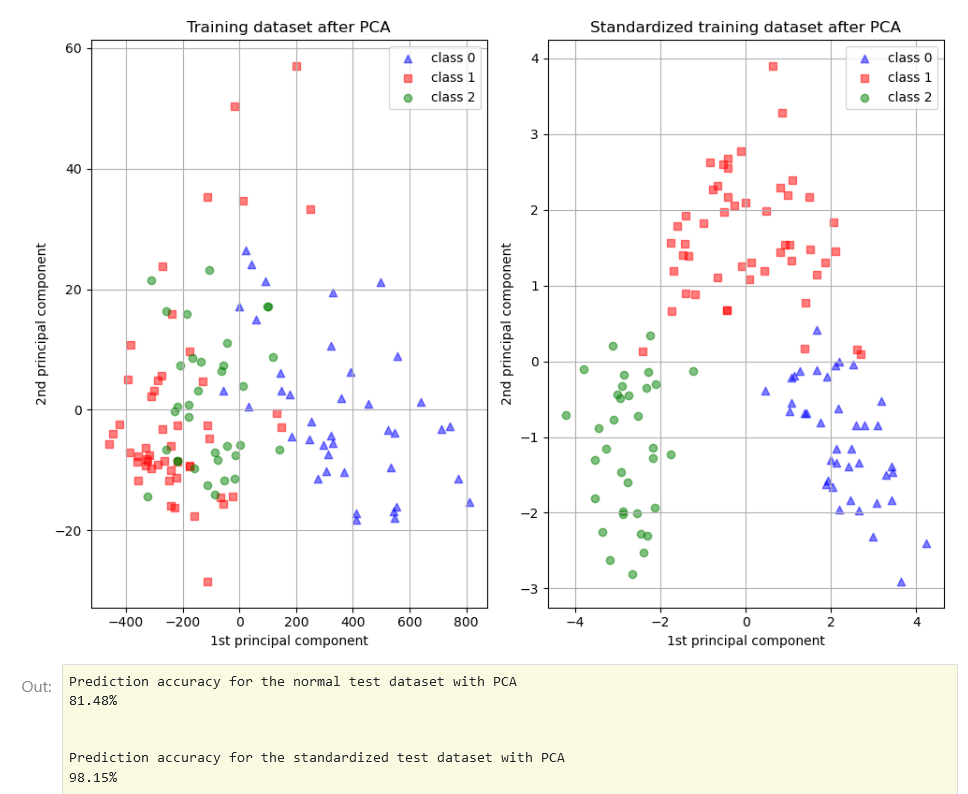

Therefore, we make use of Scikit-learn's MinMax Scaler, which standardizes features by removing their minimum and dividing by the range. Namely, it scales the columns in our dataset so as each feature is between 0 and 1.

$X_{std} = \frac{(X - X.min(axis=0))}{(X.max(axis=0) - X.min(axis=0))}$




In [ ]:
# Standardize columns with Min Max Scaler
# Mantain the dataframe structure with DataFrameMapper

def scaler(data):

    # Create mapper
    mapper = DataFrameMapper([(data.columns, MinMaxScaler())])

    # Transform the features
    standardized_features = mapper.fit_transform(data.copy(), 4)

    # Recreate dataframe
    s_f_data = pd.DataFrame(standardized_features, columns = data.columns, index = data.index) 
    return s_f_data



---


Perform PCA on the **echonest** dataset


---



In [ ]:
# Remove non-numerical columns
echonest = no_categorical(echonest)

In [ ]:
# Apply Standard Scaler
s_f_echonest = scaler(echonest)

To decide how many principal component we want to retain in our analyiss, we decide to plot the cumulative explained variance ratio in function of the number of components. We see that to explain 90% of the variance, we need around 75 components, while to explain 100% of the variability in our data we would need a little bit more than 150 components (that is, very little variance is gained by keeping more than that number of eigenvalues).

In [ ]:
def plot_pca(data, max=300, col="g"):
    pca = PCA().fit(data)
    plt.figure(figsize=(15,12))

    # Percentage of variance explained by each of the selected components
    plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
    plt.hlines(0.9, -10, max, colors=col)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variance')

    plt.grid()
    plt.show()

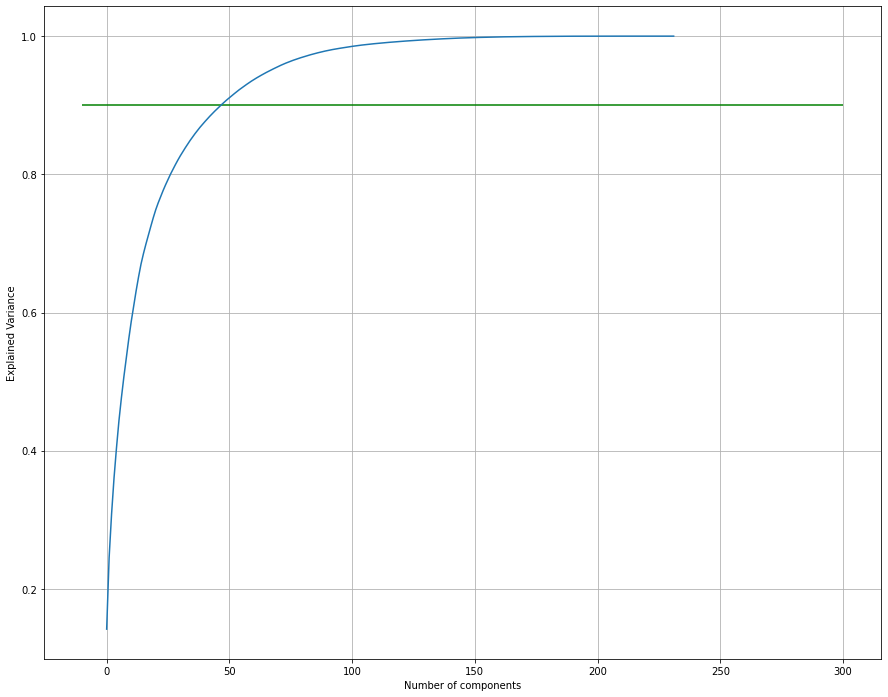

In [ ]:
# Plot explained variance ratio to find the number of components explaining 90% of the variance
plot_pca(s_f_echonest)

In [ ]:
# Project to 50 dimensions
pca = PCA(n_components=50)

# Fit the PCS
pca_echonest = pca.fit_transform(s_f_echonest)

# Total explained variance ratio
print(sum(pca.explained_variance_ratio_))

0.9076368302834654


PCA reduced the dimensionality of our dataset, allowing us to go from 519 features to 50, while mantaining more than 90% of the total variance. Below, we print the new dataset.

In [ ]:
pca_echonest_cols = ["PC_Echonest" + str(i) for i in range(1, 51)]
pca_echonest = pd.DataFrame(data = pca_echonest, columns = pca_echonest_cols)
pca_echonest.head(5)

,PC_Echonest1,PC_Echonest2,PC_Echonest3,PC_Echonest4,PC_Echonest5,PC_Echonest6,PC_Echonest7,PC_Echonest8,PC_Echonest9,PC_Echonest10,PC_Echonest11,PC_Echonest12,PC_Echonest13,PC_Echonest14,PC_Echonest15,PC_Echonest16,PC_Echonest17,PC_Echonest18,PC_Echonest19,PC_Echonest20,PC_Echonest21,PC_Echonest22,PC_Echonest23,PC_Echonest24,PC_Echonest25,PC_Echonest26,PC_Echonest27,PC_Echonest28,PC_Echonest29,PC_Echonest30,PC_Echonest31,PC_Echonest32,PC_Echonest33,PC_Echonest34,PC_Echonest35,PC_Echonest36,PC_Echonest37,PC_Echonest38,PC_Echonest39,PC_Echonest40,PC_Echonest41,PC_Echonest42,PC_Echonest43,PC_Echonest44,PC_Echonest45,PC_Echonest46,PC_Echonest47,PC_Echonest48,PC_Echonest49,PC_Echonest50
0,-0.400776,0.178103,-0.280842,0.126825,0.280444,0.422404,0.584058,-0.109254,0.243906,-0.282679,0.310520,-0.143940,-0.265827,-0.108868,0.026116,-0.206765,-0.045677,0.146304,0.143769,0.091424,0.009903,-0.005072,0.009349,0.103697,0.054662,-0.000232,0.186448,-0.153471,-0.005922,-0.094286,-0.067265,-0.074046,0.201382,0.009403,-0.073937,0.049253,0.052551,0.057132,-0.130129,-0.016351,-0.005564,0.017911,0.016869,0.012124,-0.053795,0.148541,0.048263,-0.251183,0.042051,0.022447
1,-0.618317,0.200860,-0.144294,0.541698,-0.051146,0.522598,0.088505,-0.150497,-0.275297,0.118900,0.198463,0.074409,0.062014,-0.091398,0.272091,-0.054823,0.263787,0.201881,-0.082295,0.076252,0.053489,-0.059355,0.052931,0.382180,0.123049,-0.149823,0.275879,-0.045958,0.152438,0.021809,-0.206193,0.155150,-0.040338,0.037444,0.018974,0.043705,-0.094392,-0.123256,0.000409,0.256661,0.024074,-0.093583,0.130998,-0.079535,0.041477,-0.067374,0.101971,-0.123179,-0.086211,-0.076517
2,-0.773375,0.547345,-0.126390,0.352646,0.172712,0.331561,0.060778,0.215192,-0.118147,-0.117791,0.006376,0.333599,-0.024634,0.206348,0.032023,-0.393437,0.059339,0.096655,-0.089112,0.198479,-0.160103,-0.028907,-0.207033,0.010654,-0.154569,-0.172088,-0.145524,-0.017645,-0.061289,0.036770,-0.186246,-0.038640,0.071227,-0.011676,-0.024421,0.147677,0.044494,0.099584,0.077308,0.034327,-0.081537,-0.101760,0.180659,0.013629,0.080570,0.011537,-0.159989,0.165377,0.083940,0.011619
3,-0.387913,-0.388070,0.382879,0.218027,-0.404011,-0.121101,0.717766,0.345683,0.399016,0.167159,-0.434337,0.176615,-0.076804,-0.210201,0.443501,-0.124058,0.103520,-0.005940,0.239746,0.238594,0.034434,-0.038498,0.189996,0.081367,0.077605,0.063814,-0.091489,-0.072156,-0.071582,-0.170196,0.078693,0.005171,-0.044717,0.027284,0.153890,-0.187656,-0.000616,-0.099223,0.127015,-0.042986,0.138189,-0.225710,0.143454,-0.032364,0.308861,-0.237510,-0.006773,-0.006360,0.079213,-0.015693
4,-0.400733,0.628115,0.137269,0.626410,0.385278,0.041016,0.037724,0.128712,-0.186729,-0.063819,0.101843,-0.233253,-0.222191,-0.078160,-0.023115,0.038541,-0.048146,0.045620,-0.148098,0.234208,0.096322,0.125788,-0.114072,0.213950,-0.073986,0.183621,-0.044994,0.040748,0.004885,0.079822,0.099160,0.056530,0.035949,0.130803,-0.041641,-0.102074,0.103334,0.090380,-0.124711,0.233419,-0.055428,0.031833,0.279579,-0.015141,0.085355,-0.087226,-0.038578,-0.166892,0.098167,0.064265




---




Perform PCA on the **features** dataset


---



Since we already know that we will end up woth a dataset of around 13k rows (i.e. the number of rows of the smallest dataset, that is, **echonest**), we perform the dimensionality reduction only on the first 13k rows of **features**.

In [ ]:
features_p = features.iloc[:len(echonest)]

In [ ]:
# Remove non-numerical columns
features_p = no_categorical(features_p)

In [ ]:
# Standardize the data
s_f_features = scaler(features_p)

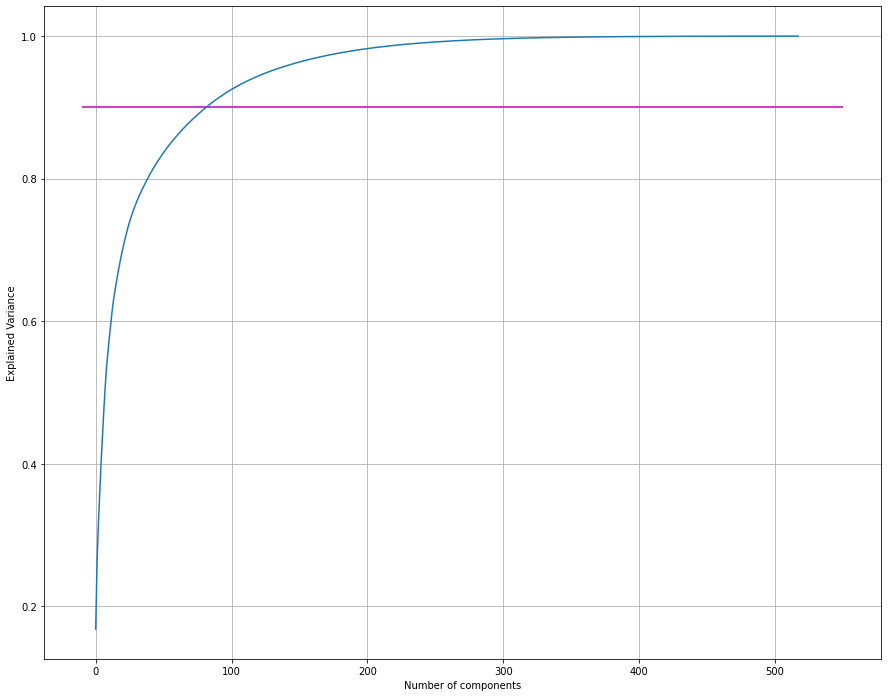

In [ ]:
# Plot explained variance ratio to find the number of components explaining 90% of the variance
plot_pca(s_f_features, max=550, col="m")

In [ ]:
# Project to 85 dimensions
pca = PCA(n_components = 85)

# Fit the PCS
pca_features = pca.fit_transform(s_f_features)

# Total explained variance ratio
print(sum(pca.explained_variance_ratio_))

0.9037518799421731


In [ ]:
pca_features_cols = ["PC_Features" + str(i) for i in range(1, 86)]
pca_features = pd.DataFrame(data = pca_features, columns = pca_features_cols)
pca_features.head(5)

,PC_Features1,PC_Features2,PC_Features3,PC_Features4,PC_Features5,PC_Features6,PC_Features7,PC_Features8,PC_Features9,PC_Features10,PC_Features11,PC_Features12,PC_Features13,PC_Features14,PC_Features15,PC_Features16,PC_Features17,PC_Features18,PC_Features19,PC_Features20,PC_Features21,PC_Features22,PC_Features23,PC_Features24,PC_Features25,PC_Features26,PC_Features27,PC_Features28,PC_Features29,PC_Features30,PC_Features31,PC_Features32,PC_Features33,PC_Features34,PC_Features35,PC_Features36,PC_Features37,PC_Features38,PC_Features39,PC_Features40,...,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70,PC_Features71,PC_Features72,PC_Features73,PC_Features74,PC_Features75,PC_Features76,PC_Features77,PC_Features78,PC_Features79,PC_Features80,PC_Features81,PC_Features82,PC_Features83,PC_Features84,PC_Features85
0,0.434400,-0.168277,0.681979,0.546368,0.605345,0.379967,0.216700,0.425286,-0.043495,-0.269572,-0.106234,-0.324494,0.284254,-0.055318,-0.211176,0.244087,0.189430,0.132836,0.249813,-0.010537,0.183621,-0.005358,-0.159908,0.227441,0.130408,0.096949,-0.097530,-0.163151,0.084957,0.123556,0.057832,-0.133685,-0.076191,0.042898,-0.103945,0.023451,0.025323,0.067793,-0.008169,0.012927,...,0.022687,-0.120834,-0.038426,0.031568,-0.087750,0.034677,-0.046040,-0.123587,0.047717,-0.092694,0.046183,0.001034,0.043219,-0.066010,0.043178,0.100868,-0.006748,-0.069281,0.052425,-0.225912,-0.004641,0.038223,-0.081714,0.044354,-0.038268,-0.048303,-0.046119,0.024180,0.015448,-0.104224,0.139845,-0.056225,-0.035442,0.041951,0.002638,-0.099460,-0.074187,-0.017899,0.014736,0.011832
1,0.653151,-0.580587,0.572034,-0.425296,-0.037312,-0.166859,0.581287,0.041840,0.110925,0.268161,0.407622,-0.242537,0.421512,-0.154326,-0.178958,0.003758,-0.086127,0.082060,0.229428,0.049251,0.196254,-0.223409,0.024025,0.073500,0.075154,0.234800,-0.014106,-0.257797,0.103920,0.006578,0.251851,0.077153,-0.022262,-0.063180,0.032310,0.057905,0.119307,0.077063,-0.064524,-0.006534,...,-0.023439,-0.062853,-0.062577,0.012888,0.045295,0.138807,0.049373,-0.085167,0.060746,0.003496,-0.085856,0.049019,0.042878,0.018357,-0.094717,-0.092935,-0.120485,-0.111414,-0.023006,-0.051861,-0.045376,-0.053529,0.007650,0.009340,-0.049048,0.099281,-0.036381,0.001810,0.054383,-0.083817,0.090898,-0.011886,0.098152,0.064413,0.071120,-0.054751,-0.021756,0.143078,-0.070760,-0.050837
2,0.332231,-0.164830,0.487514,-0.181070,0.232847,-0.189310,0.082904,0.186204,0.120817,-0.239141,-0.025812,-0.025281,0.100649,-0.125592,-0.337074,0.154130,0.220016,0.221047,0.196441,-0.053144,-0.205955,-0.154878,0.387279,0.104716,0.199478,-0.059088,-0.043884,-0.197042,-0.057018,-0.019772,0.378688,0.094194,-0.040498,0.031461,-0.039742,-0.111277,-0.119651,0.038027,-0.041455,0.009923,...,0.042972,-0.221276,-0.000938,0.045411,-0.085100,0.247058,0.047216,0.103439,-0.131245,-0.137551,-0.060966,-0.013254,0.049408,0.029329,-0.107579,0.059509,0.010548,-0.206630,-0.031322,0.134400,-0.059151,-0.119858,-0.231766,0.010528,-0.058618,0.052537,-0.009244,0.055901,0.053410,0.079015,-0.004850,-0.056491,-0.053281,-0.132279,0.059382,-0.063611,-0.043652,0.066864,-0.084687,-0.035049
3,0.763848,0.213669,0.461183,-0.160939,-0.216860,-0.134011,0.371943,0.001518,-0.275988,0.185147,0.062009,0.382167,0.275180,0.119763,0.063959,0.099529,0.388493,-0.131586,0.200989,-0.078438,-0.303159,-0.242518,0.031415,-0.402125,0.092415,-0.124658,0.068772,-0.214645,0.326372,0.068025,-0.041578,0.125369,0.108295,0.031316,-0.068129,-0.014513,0.053349,0.163117,-0.011075,-0.019389,...,0.089710,-0.006683,-0.037227,-0.100293,-0.163215,0.058986,-0.156488,-0.051916,0.168692,-0.146098,-0.157659,0.022696,0.090823,0.001873,0.122727,0.041168,0.089232,-0.021672,-0.091868,0.115651,0.052026,-0.02999

 The **tracks** csv already contains a small number of columns, therefore we will not perform PCA on it. 

In [ ]:
# Reset index so as to match with the indeces of the dataframes coming from the PCA analysis
tracks = tracks.reset_index(drop=True)

In [ ]:
# Create new dataframe where some tracks features will be standardized
s_f_tracks = tracks.copy()

In [ ]:
# Convert language column to categorical
s_f_tracks['track_language_code'] = s_f_tracks.track_language_code.astype('category')

# Convert categories to numbers (e.g., en = 9, es = 10)
cat_columns = s_f_tracks.select_dtypes(['category']).columns
s_f_tracks[cat_columns] = s_f_tracks[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
s_f_tracks.head()

,artist_name,track_duration,track_genre_top,track_genres_all,track_genres,track_language_code,track_genre_id
0,AWOL,168,Hip-Hop,[21],[21],9,21
1,AWOL,237,Hip-Hop,[21],[21],9,21
2,AWOL,206,Hip-Hop,[21],[21],9,21
3,Kurt Vile,161,Pop,[10],[10],9,10
4,Nicky Cook,311,Pop,"[17, 10, 76, 103]","[76, 103]",9,76


In [ ]:
# Reset index so as to perform the merge with echonest and features
s_f_tracks['track_language_code'] = s_f_tracks.track_language_code.astype('category')

In [ ]:
# Standardize the columns track_duration and track_language_code
# using scikit-learn Min Max Scaler
col_names = ['track_duration', "track_language_code",]
feature_names = s_f_tracks[col_names]

# Fit MinMaxScaler to the selected columns
scaler_minmax = MinMaxScaler().fit(feature_names.values)
feature_names = scaler_minmax.transform(feature_names.values)

# Replace columns in the original dataset
s_f_tracks[col_names] = feature_names
s_f_tracks.head()

,artist_name,track_duration,track_genre_top,track_genres_all,track_genres,track_language_code,track_genre_id
0,AWOL,0.009155,Hip-Hop,[21],[21],0.204545,21
1,AWOL,0.012916,Hip-Hop,[21],[21],0.204545,21
2,AWOL,0.011226,Hip-Hop,[21],[21],0.204545,21
3,Kurt Vile,0.008774,Pop,[10],[10],0.204545,10
4,Nicky Cook,0.016948,Pop,"[17, 10, 76, 103]","[76, 103]",0.204545,76


In [ ]:
# Merge the three dataframes into one (df_merged)
dfs = [s_f_tracks, pca_echonest, pca_features]
df_merged = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True,
                                           how='inner'), dfs)

Our final dataset contains 13129 observations and 145 features, which we will be using to perform K-Means.

In [ ]:
df_merged.shape

(13129, 142)

In [ ]:
# We take a look to our final dataset.
df_merged.head(10)

,artist_name,track_duration,track_genre_top,track_genres_all,track_genres,track_language_code,track_genre_id,PC_Echonest1,PC_Echonest2,PC_Echonest3,PC_Echonest4,PC_Echonest5,PC_Echonest6,PC_Echonest7,PC_Echonest8,PC_Echonest9,PC_Echonest10,PC_Echonest11,PC_Echonest12,PC_Echonest13,PC_Echonest14,PC_Echonest15,PC_Echonest16,PC_Echonest17,PC_Echonest18,PC_Echonest19,PC_Echonest20,PC_Echonest21,PC_Echonest22,PC_Echonest23,PC_Echonest24,PC_Echonest25,PC_Echonest26,PC_Echonest27,PC_Echonest28,PC_Echonest29,PC_Echonest30,PC_Echonest31,PC_Echonest32,PC_Echonest33,...,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70,PC_Features71,PC_Features72,PC_Features73,PC_Features74,PC_Features75,PC_Features76,PC_Features77,PC_Features78,PC_Features79,PC_Features80,PC_Features81,PC_Features82,PC_Features83,PC_Features84,PC_Features85
0,AWOL,0.009155,Hip-Hop,[21],[21],0.204545,21,-0.400776,0.178103,-0.280842,0.126825,0.280444,0.422404,0.584058,-0.109254,0.243906,-0.282679,0.310520,-0.143940,-0.265827,-0.108868,0.026116,-0.206765,-0.045677,0.146304,0.143769,0.091424,0.009903,-0.005072,0.009349,0.103697,0.054662,-0.000232,0.186448,-0.153471,-0.005922,-0.094286,-0.067265,-0.074046,0.201382,...,0.022687,-0.120834,-0.038426,0.031568,-0.087750,0.034677,-0.046040,-0.123587,0.047717,-0.092694,0.046183,0.001034,0.043219,-0.066010,0.043178,0.100868,-0.006748,-0.069281,0.052425,-0.225912,-0.004641,0.038223,-0.081714,0.044354,-0.038268,-0.048303,-0.046119,0.024180,0.015448,-0.104224,0.139845,-0.056225,-0.035442,0.041951,0.002638,-0.099460,-0.074187,-0.017899,0.014736,0.011832
1,AWOL,0.012916,Hip-Hop,[21],[21],0.204545,21,-0.618317,0.200860,-0.144294,0.541698,-0.051146,0.522598,0.088505,-0.150497,-0.275297,0.118900,0.198463,0.074409,0.062014,-0.091398,0.272091,-0.054823,0.263787,0.201881,-0.082295,0.076252,0.053489,-0.059355,0.052931,0.382180,0.123049,-0.149823,0.275879,-0.045958,0.152438,0.021809,-0.206193,0.155150,-0.040338,...,-0.023439,-0.062853,-0.062577,0.012888,0.045295,0.138807,0.049373,-0.085167,0.060746,0.003496,-0.085856,0.049019,0.042878,0.018357,-0.094717,-0.092935,-0.120485,-0.111414,-0.023006,-0.051861,-0.045376,-0.053529,0.007650,0.009340,-0.049048,0.099281,-0.036381,0.001810,0.054383,-0.083817,0.090898,-0.011886,0.098152,0.064413,0.071120,-0.054751,-0.021756,0.143078,-0.070760,-0.050837
2,AWOL,0.011226,Hip-Hop,[21],[21],0.204545,21,-0.773375,0.547345,-0.126390,0.352646,0.172712,0.331561,0.060778,0.215192,-0.118147,-0.117791,0.006376,0.333599,-0.024634,0.206348,0.032023,-0.393437,0.059339,0.096655,-0.089112,0.198479,-0.160103,-0.028907,-0.207033,0.010654,-0.154569,-0.172088,-0.145524,-0.017645,-0.061289,0.036770,-0.186246,-0.038640,0.071227,...,0.042972,-0.221276,-0.000938,0.045411,-0.085100,0.247058,0.047216,0.103439,-0.131245,-0.137551,-0.060966,-0.013254,0.049408,0.029329,-0.107579,0.059509,0.010548,-0.206630,-0.031322,0.134400,-0.059151,-0.119858,-0.231766,0.010528,-0.058618,0.052537,-0.009244,0.055901,0.053410,0.079015,-0.004850,-0.056491,-0.053281,-0.132279,0.059382,-0.063611,-0.043652,0.066864,-0.084687,-0.035049
3,Kurt Vile,0.008774,Pop,[10],[10],0.204545,10,-0.387913,-0.388070,0.382879,0.218027,-0.404011,-0.121101,0.717766,0.345683,0.399016,0.167159,-0.434337,0.176615,-0.076804,-0.210201,0.443501,-0.124058,0.103520,-0.005940,0.239746,0.238594,0.034434,-0.038498,0.189996,0.081367,0.077605,0.063814,-0.091489,-0.072156,-0.071582,-0.170196,0.078693,0.005171,-0.044717,...,0.089710,-0.006683,-0.037227,-0.100293,-0.163215,0.058986,-0.156488,-0.051916,0.168692,-0.146098,-0.157659,0.022696,0.090823,0.001873,0.122727,0.041168,0.089232,-0.021672,-0.091868,0.115651,0.052026,-0.029996,0.139883,0.009619,0.072944,-0.149496,-0.042487,0.068358,0.014117,-0.18

# **K-Means Algorithm**

K-Means from scratch

In [ ]:
def kmeans(DataPoints, k):
    
    # In which cluster each data will considered
    Clusters = np.zeros(DataPoints.shape[0])
    
    # select k random centroids
    RandomIndexes = random.sample(range(0, DataPoints.shape[0]), k)
        
    # Now we pick our random centroids
    Centroids = DataPoints[RandomIndexes, :]

    while True:
    
        # Now we go through our datapoints 
        for DataIndex, DataPoint in enumerate(DataPoints):
            
            # Default Values for the minimumDistance and Cluster
            MinimumDistance = float('inf')
            ClusterIndex = 0
            
            # Here we will check the distance between all the centroids our current datapoint
            for centerIndex, centroid in enumerate(Centroids):
                
                # Compute the distance 
                Distance = np.sqrt(sum((centroid - DataPoint)**2))
                
                # Minimum distance so far
                if Distance < MinimumDistance:
                    MinimumDistance = Distance
                    ClusterIndex = centerIndex
            
            # Take the most similar cluster
            Clusters[DataIndex] = ClusterIndex
                   
        New_Centroids = pd.DataFrame(DataPoints).groupby(by = Clusters).mean().values
    
        # if centroids are same then leave
        if np.array_equal(Centroids, New_Centroids):
            break
        
        Centroids = New_Centroids
        
    return Centroids, Clusters.astype('int32')

# Elbow method

The Elbow method looks at the total WSS as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t improve much better the total WSS.

In order to find how many number of clusters we should take to cluster our data we should use some metrics to somehow give us the optimal number of cluster we should pick. 

Elbow method, will run the K-means algorithm with different number of clusters and for each of them will compute the distance between all of the points assigned to a cluster with their cluster.

We will see that this distance will be decreased when we pick greater number for the number of clusters, we will pick the one that doesn't change this distance significantly comparing with the next number of clusters. 

In [ ]:
# By calling this function we will compute the distance of each point in each cluster 
# with its centroid
def Distortion(DataPoints, Centroids, Cluster):
    
    # To sum up all the distortions 
    SumOfDistortion = 0 
    
    # For all the data points
    for DataIndex, DataPoint in enumerate(DataPoints):
        
        # Take the cluster this data point was assigned to 
        GivenCluster = Cluster[DataIndex]
        
        # Take the centroid of the cluster of this data point
        CentroidOfCluster = Centroids[int(GivenCluster)]
        
        # Compute the distance between the data point and the centroid
        SumOfDistortion += np.sqrt(sum((CentroidOfCluster - DataPoint)**2))
        
        
    return SumOfDistortion

# Silhouette Score

In [ ]:
def Silhouette (DataPoints, Clusters):
    
    # Number of items in each cluster
    Items_per_cluster = Counter(Clusters)
    
    # If we have just one cluster it doesn't make sense to do thi process for 
    if len(Items_per_cluster) == 1:
        return 0
    
    # Sum of all silhuoette over all data points
    Silhuoette_Sum = 0 
    
    for Main_Index, Main_DataPoint in enumerate(DataPoints):
        
        # Here we will store the distance between the point and all the points 
        # in a specific cluster
        Cluster_Distance_list = np.zeros(len(Items_per_cluster.keys()))
        
        # The cluster of the data point 
        DataPoint_cluster = Clusters[Main_Index]
        
        # Dictionary to store the 
        for Other_Index, Other_DataPoint in enumerate(DataPoints):
            
            if not np.array_equal(Main_DataPoint, Other_DataPoint):
                
                # Check the distance between a specific and other point 
                Distance = np.sqrt(sum((Main_DataPoint - Other_DataPoint)**2))
                
                # Sum the distance of this point with the other datapoints in that cluster
                Cluster_Distance_list[int(Clusters[Other_Index])] += Distance
        
        # Here we will get the distance in cluster and minimum neighbor cluster
        In_cluster_distance, Closest_neighbor, Neighbor_cluster_distance = 0, 0,  float('inf')
        
        for ClusterIndex in Items_per_cluster:
            
            # If this is the cluster of the main datapoint
            if ClusterIndex == DataPoint_cluster:
                # Take the in cluster distance 
                In_cluster_distance = Cluster_Distance_list[ClusterIndex]
            else: 
                
                # If the distance with this cluster is less
                if Cluster_Distance_list[ClusterIndex] < Neighbor_cluster_distance: 
                    
                    # Take this cluster as the closest to the data point
                    Neighbor_cluster_distance = Cluster_Distance_list[ClusterIndex]
                    Closest_neighbor = ClusterIndex
        
        # Now we should compute the mean distance within each cluster
        
        # We will decrease by one as we don't include the main data point
        if Items_per_cluster[DataPoint_cluster] != 1:
            Mean_in_cluster = Cluster_Distance_list[DataPoint_cluster] / (Items_per_cluster[DataPoint_cluster] - 1)
        else: 
            # When this is the only point in the cluster 
            Mean_in_cluster = 0

        # The distance with the closest neighbor
        Mean_in_closest_cluster = Cluster_Distance_list[Closest_neighbor] / Items_per_cluster[Closest_neighbor]
        
        # Summing up all the silhouette values
        Silhuoette_Sum  +=  (Mean_in_closest_cluster - Mean_in_cluster) / max(Mean_in_closest_cluster, Mean_in_cluster)
    
    return Silhuoette_Sum/len(DataPoints)
        


# Optimal number of clusters

To apply the K-Means algorithm written above, we first drop non-numerical variables.

In [ ]:
df_merged = no_categorical(df_merged)

In [ ]:
# We will store the sum of distortions for each number of clusters
Distortion_list = []

# We will store the Sillhuoette score for each number of clusters
Silhuoette_list = []

# We will set her for how many clusters we want to check 
Number_of_Test = 10

# Trying different number of clusters
for k in range(2, Number_of_Test + 1):
    Centroids, Clusters = kmeans(df_merged.values, k)
  
    # WCSS (Within cluster sum of square)
    Distortion_Value = Distortion(df_merged.values, Centroids, Clusters)
    Distortion_list.append(Distortion_Value)
    
    # Computing the Silhuoette score
    #Silhuoette_coefficient = Silhouette(df_merged.values, Clusters)
    # Silhuoette_list.append(Silhuoette_coefficient)

## Showing the result

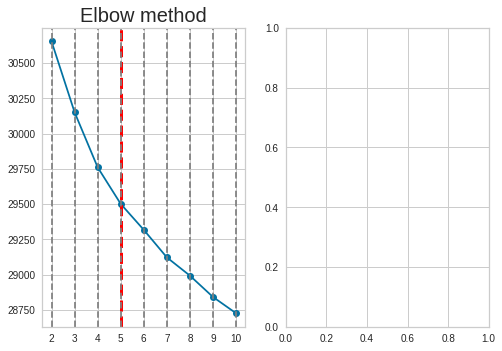

In [ ]:
# We need two subplots
fig, ax = plt.subplots(1, 2)

# Taking the values for the x and y axis
x_axis = list(map(str, list(range(2, Number_of_Test + 1))))

# Plot the elbow method's values
ax[0].plot(x_axis , Distortion_list, marker = 'o')

# Plot the silhuoette score value's
#ax[1].plot(x_axis, Silhuoette_list, marker = 'o')
    
    
# Pick the elbow point in elbow method 
kn = KneeLocator(range(2, Number_of_Test + 1), Distortion_list, curve='convex', direction='decreasing')

# Show the best value for the cluster with different number 
ax[0].axvline(kn.knee - 2, linestyle = 'dashed', color = 'red', linewidth = 3)

# Show the least precision 
#ax[1].axhline(y = .70, linestyle = 'dashed', color = 'red', linewidth = 3)
# We put vertical lines to better identify the points
for xv in x_axis:
    ax[0].axvline(x=xv, color='gray', linestyle='--')
    #ax[1].axvline(x=xv, color='gray', linestyle='--')
    
ax[0].set_title('Elbow method', fontsize = 20)
#ax[1].set_title('Silhuoette score', fontsize = 20)
plt.show()

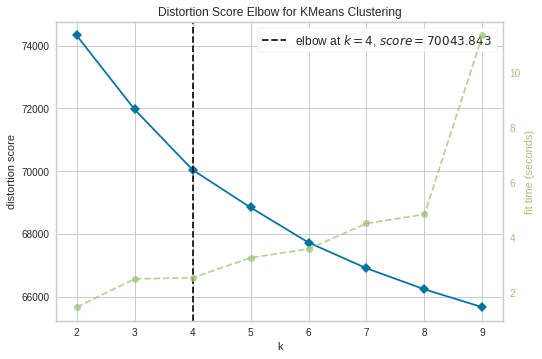

In [ ]:
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,10), metric = "distortion")
visualizer.fit(df_merged) # Fit the data to the visualizer
visualizer.show();  # Finalize and render the figure

We see that the Elbow method we implemented tells us that the optimal number of clusters for our dataset is 5, while the one from scikit-learn says 4.

# Applying the K-means

We now apply our version of the k-means

In [ ]:
# The default value for the number of clusters will be the one picked by the elbow method
number_of_clusters = 4

# We will take the results
Centroids , Clusters = kmeans(df_merged.values, number_of_clusters)


In [ ]:
# Dataframe with "Cluster" column
df_merged.insert(0, "Cluster", Clusters)
df_merged.head()

,Cluster,track_duration,track_language_code,PC_Echonest1,PC_Echonest2,PC_Echonest3,PC_Echonest4,PC_Echonest5,PC_Echonest6,PC_Echonest7,PC_Echonest8,PC_Echonest9,PC_Echonest10,PC_Echonest11,PC_Echonest12,PC_Echonest13,PC_Echonest14,PC_Echonest15,PC_Echonest16,PC_Echonest17,PC_Echonest18,PC_Echonest19,PC_Echonest20,PC_Echonest21,PC_Echonest22,PC_Echonest23,PC_Echonest24,PC_Echonest25,PC_Echonest26,PC_Echonest27,PC_Echonest28,PC_Echonest29,PC_Echonest30,PC_Echonest31,PC_Echonest32,PC_Echonest33,PC_Echonest34,PC_Echonest35,PC_Echonest36,PC_Echonest37,...,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70,PC_Features71,PC_Features72,PC_Features73,PC_Features74,PC_Features75,PC_Features76,PC_Features77,PC_Features78,PC_Features79,PC_Features80,PC_Features81,PC_Features82,PC_Features83,PC_Features84,PC_Features85
0,1,0.009155,0.204545,-0.400776,0.178103,-0.280842,0.126825,0.280444,0.422404,0.584058,-0.109254,0.243906,-0.282679,0.310520,-0.143940,-0.265827,-0.108868,0.026116,-0.206765,-0.045677,0.146304,0.143769,0.091424,0.009903,-0.005072,0.009349,0.103697,0.054662,-0.000232,0.186448,-0.153471,-0.005922,-0.094286,-0.067265,-0.074046,0.201382,0.009403,-0.073937,0.049253,0.052551,...,0.022687,-0.120834,-0.038426,0.031568,-0.087750,0.034677,-0.046040,-0.123587,0.047717,-0.092694,0.046183,0.001034,0.043219,-0.066010,0.043178,0.100868,-0.006748,-0.069281,0.052425,-0.225912,-0.004641,0.038223,-0.081714,0.044354,-0.038268,-0.048303,-0.046119,0.024180,0.015448,-0.104224,0.139845,-0.056225,-0.035442,0.041951,0.002638,-0.099460,-0.074187,-0.017899,0.014736,0.011832
1,1,0.012916,0.204545,-0.618317,0.200860,-0.144294,0.541698,-0.051146,0.522598,0.088505,-0.150497,-0.275297,0.118900,0.198463,0.074409,0.062014,-0.091398,0.272091,-0.054823,0.263787,0.201881,-0.082295,0.076252,0.053489,-0.059355,0.052931,0.382180,0.123049,-0.149823,0.275879,-0.045958,0.152438,0.021809,-0.206193,0.155150,-0.040338,0.037444,0.018974,0.043705,-0.094392,...,-0.023439,-0.062853,-0.062577,0.012888,0.045295,0.138807,0.049373,-0.085167,0.060746,0.003496,-0.085856,0.049019,0.042878,0.018357,-0.094717,-0.092935,-0.120485,-0.111414,-0.023006,-0.051861,-0.045376,-0.053529,0.007650,0.009340,-0.049048,0.099281,-0.036381,0.001810,0.054383,-0.083817,0.090898,-0.011886,0.098152,0.064413,0.071120,-0.054751,-0.021756,0.143078,-0.070760,-0.050837
2,1,0.011226,0.204545,-0.773375,0.547345,-0.126390,0.352646,0.172712,0.331561,0.060778,0.215192,-0.118147,-0.117791,0.006376,0.333599,-0.024634,0.206348,0.032023,-0.393437,0.059339,0.096655,-0.089112,0.198479,-0.160103,-0.028907,-0.207033,0.010654,-0.154569,-0.172088,-0.145524,-0.017645,-0.061289,0.036770,-0.186246,-0.038640,0.071227,-0.011676,-0.024421,0.147677,0.044494,...,0.042972,-0.221276,-0.000938,0.045411,-0.085100,0.247058,0.047216,0.103439,-0.131245,-0.137551,-0.060966,-0.013254,0.049408,0.029329,-0.107579,0.059509,0.010548,-0.206630,-0.031322,0.134400,-0.059151,-0.119858,-0.231766,0.010528,-0.058618,0.052537,-0.009244,0.055901,0.053410,0.079015,-0.004850,-0.056491,-0.053281,-0.132279,0.059382,-0.063611,-0.043652,0.066864,-0.084687,-0.035049
3,2,0.008774,0.204545,-0.387913,-0.388070,0.382879,0.218027,-0.404011,-0.121101,0.717766,0.345683,0.399016,0.167159,-0.434337,0.176615,-0.076804,-0.210201,0.443501,-0.124058,0.103520,-0.005940,0.239746,0.238594,0.034434,-0.038498,0.189996,0.081367,0.077605,0.063814,-0.091489,-0.072156,-0.071582,-0.170196,0.078693,0.005171,-0.044717,0.027284,0.153890,-0.187656,-0.000616,...,0.089710,-0.006683,-0.037227,-0.100293,-0.163215,0.058986,-0.156488,-0.051916,0.168692,-0.146098,-0.157659,0.022696,0.090823,0.001873,0.122727,0.041168,0.089232,-0.021672,-0.091868,0.115651,0.052026,-0.029996,0.139883,0.009619,0.072944

# Visualizing the results

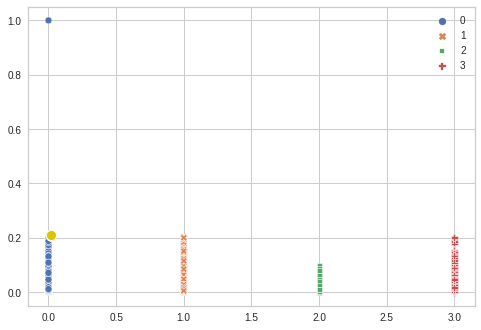

<Figure size 1080x864 with 0 Axes>

In [ ]:
# Group the datapoints that share the same cluster
sns.scatterplot(x = df_merged.values[:,0], y = df_merged.values[:, 1], hue = Clusters, style = Clusters, palette="deep")

# Show the center of the clusters
sns.scatterplot(x = Centroids[:,0], y = Centroids[:, 1], s= 100, color='y')

plt.figure(figsize=(15,12))
plt.show()

# **2.4: Analysing your results!**

We now want to explain the characteristics of our clusters. To carry out this task, we first select some variables that we determine to be relevant in identifying the genre of a song. 

\\


We ended up choosing the following columns: 


*   From the **echonest** dataset:


1.   audio_features_acousticness;
2.  audio_features_danceability;
3.   audio_features_energy;
4.  audio_features_instrumentalness;
5. audio_features_liveness;
6. audio_features_speechiness;
7. audio_features_tempo


*   From the **tracks** dataset:



8.   track_duration
9.   track_language_code


 	 	 	 	 	 	

In [ ]:
# create new dataframe
df = pd.DataFrame()

# insert the chosen columns from the echonest dataset
# they are the first 7 columns of the dataset
for col in range(7):
    df.insert(col, list(echonest.columns)[col], echonest[list(echonest.columns)[col]]) 

# insert the two columns from tracks
df.insert(7, "track_duration", tracks["track_duration"])
df.insert(8, "track_language_code", tracks["track_language_code"])

# reset index to match (the order of the rows doesn't change)
df = df.reset_index(drop=True)
# insert clusters
df.insert(9, "cluster1", df_merged["Cluster"]) # clusters from our kmeans

In [ ]:
df.head()

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,track_duration,track_language_code,cluster1
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,206.0,en,1
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,161.0,en,1
2,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,181.0,en,1
3,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,837.0,en,2
4,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,273.0,en,1


In [ ]:
# Divide numerical columns into 4 categories such that:
# if their values are between 0 and 0.25, they are "Low";
# if their values are between 0.25 and 0.50, they are "Medium";
# if their values are between 0.50 and 0.75, they are "High";
# if their values are between 0.75 and 1, they are "Great".

labels=['Low', 'Medium', 'High', 'Great']
for col in range(8):
    df[list(df.columns)[col]] = pd.qcut(df[list(df.columns)[col]], [0, .25, .5, .75, 1.], labels=labels)

In [ ]:
df.head()

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,track_duration,track_language_code,cluster1
0,Medium,Great,High,Low,High,Great,Great,Medium,en,1
1,Medium,High,Great,Low,Medium,Great,High,Medium,en,1
2,Low,Great,High,Low,Great,Great,Medium,Medium,en,1
3,Great,Great,Great,Great,Medium,Low,Medium,Great,en,2
4,Medium,High,High,Low,Low,Great,Medium,High,en,1


# **PIVOTS**

To create each pivot table, we first select the variable of interest and the cluster column. Then, we make use of the pivot_table function from pandas, selecting as *index* the variable we selected earlier (one at a time) and as *columns* the cluster feature. Lastly, we compute the percentage for each column.



---
audio_features_acousticness

---




**Kmeans from scratch**

In [ ]:
# pivot for audio_features_acousticness
pivot1_cols = ['audio_features_acousticness', 'cluster1']

pivot1 = df[pivot1_cols]

pivot1 = pd.pivot_table(data=pivot1, 
                        index='audio_features_acousticness', 
                        columns='cluster1', 
                        aggfunc=len)

pivot1 = round(pivot1 / pivot1.sum() * 100, 2)

In [ ]:
pivot1

cluster1,0,1,2,3
audio_features_acousticness,,,,
Low,1.96,38.51,26.65,28.40
Medium,7.57,32.69,28.57,28.37
High,26.17,21.04,27.91,25.90
Great,64.30,7.76,16.88,17.33


Considering the pivot for audio_features_acousticness, we observe that:
- in the cluster O there's a tiny percentage of "Low" values and a significat one for the "Great" values. This means that it's considerably easier to find tracks with great acousticness;
- in the clusters 1, 2 and 3, the percentages associated to the categories are pretty balanced between them with the exception of the "Great" category.


---
audio_features_danceability

---

**Kmeans from scratch**

In [ ]:
# pivot for audio_features_danceability
pivot2_cols = ['audio_features_danceability', 'cluster1']

pivot2 = df[pivot2_cols]

pivot2 = pd.pivot_table(data=pivot2, 
                        index='audio_features_danceability', 
                        columns='cluster1', 
                        aggfunc=len)

pivot2 = round(pivot2 / pivot2.sum() * 100, 2)

pivot2

cluster1,0,1,2,3
audio_features_danceability,,,,
Low,30.90,27.04,21.86,20.22
Medium,30.87,23.53,24.31,22.07
High,24.78,23.04,26.52,26.09
Great,13.46,26.39,27.31,31.62


Considering the pivot for audio_features_acousticness, we observe that:
- in the cluster O there's a smaller percentage of "Great" values, instead the others categories are all similar. This is exactly the opposite behavior of the same cluster, considering the acousticness;
- in the clusters 1, 2 and 3 the distribution of the percentages is equal between the classes.

The particular thing that we notice is that in the cluster 0, it is difficult to find songs with low acousticness but it's very easy finding the ones with low and medium danceability.



---

audio_features_energy

---



**Kmeans from scratch**

In [ ]:
# pivot for audio_features_energy
pivot3_cols = ['audio_features_energy', 'cluster1']

pivot3 = df[pivot3_cols]

pivot3 = pd.pivot_table(data=pivot3, 
                        index='audio_features_energy', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot3 = round(pivot3 / pivot3.sum() * 100, 2)

pivot3

cluster1,0,1,2,3
audio_features_energy,,,,
Low,72.68,2.85,15.29,17.03
Medium,24.17,18.53,29.10,29.55
High,3.08,34.85,30.15,28.43
Great,0.07,43.77,25.46,24.99


Considering the pivot for audio_features_energy, we observe that:
- in che cluster 0 there's a huge amount of "Low" and a tiny percentage of "High" and "Great". This means that it's difficult to find songs with a lot of energy, instead it's easier finding the ones that are slower;
- in the cluster 1 there's a little percentage of "Low" values, but there's a high percentage of "Great" values;
- in the cluters 2 and 3, the values are well distibuted.


We had to expect to have this output for the cluster 0 because it's characterized by a high percentage of danceability, so it is clear that it can't be so energic.




---

audio_features_instrumentalness

---



**Kmeans from scratch**

In [ ]:
# pivot for audio_features_instrumentalness
pivot4_cols = ['audio_features_instrumentalness', 'cluster1']

pivot4 = df[pivot4_cols]

pivot4 = pd.pivot_table(data=pivot4, 
                        index='audio_features_instrumentalness', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot4 = round(pivot4 / pivot4.sum() * 100, 2)

pivot4

cluster1,0,1,2,3
audio_features_instrumentalness,,,,
Low,21.84,24.99,25.50,27.42
Medium,18.97,26.75,27.41,26.15
High,21.60,27.45,24.34,25.78
Great,37.59,20.81,22.75,20.64


Considering the pivot for audio_features_instrumentalness, we observe that in all the clusters there's an equal distribution of the percentages.



---

audio_features_liveness

---



**Kmeans from scratch**

In [ ]:
# pivot for audio_features_liveness
pivot5_cols = ['audio_features_liveness', 'cluster1']

pivot5 = df[pivot5_cols]

pivot5 = pd.pivot_table(data=pivot5, 
                        index='audio_features_liveness', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot5 = round(pivot5 / pivot5.sum() * 100, 2)

pivot5

cluster1,0,1,2,3
audio_features_liveness,,,,
Low,22.11,26.26,25.10,26.06
Medium,33.54,20.16,22.06,25.69
High,22.68,26.57,27.31,23.11
Great,21.67,27.01,25.53,25.14


In almost all clusters, songs are equally characterized by the liveness.



---

audio_features_speechiness

---



In [ ]:
# pivot for audio_features_speechiness
pivot6_cols = ['audio_features_speechiness', 'cluster1']

pivot6 = df[pivot6_cols]

pivot6 = pd.pivot_table(data=pivot6, 
                        index='audio_features_speechiness', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot6 = round(pivot6 / pivot6.sum() * 100, 2)

pivot6

cluster1,0,1,2,3
audio_features_speechiness,,,,
Low,33.87,21.02,24.01,22.62
Medium,31.27,22.94,23.02,23.59
High,19.10,28.54,25.36,25.81
Great,15.75,27.50,27.61,27.97


Considering the pivot for audio_features_speechiness, we observe that: 
- in cluster 0 there are more "Low" values than "Great". This means that in cluster 0 it's more difficult to find songs with people actually speaking than finding songs with no speeches;
- in the other clusters there's an equal distribution of the speechiness.



---

audio_features_tempo

---



In [ ]:
# pivot for audio_features_tempo
pivot7_cols = ['audio_features_tempo', 'cluster1']

pivot7 = df[pivot7_cols]

pivot7 = pd.pivot_table(data=pivot7, 
                        index='audio_features_tempo', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot7 = round(pivot7 / pivot7.sum() * 100, 2)

pivot7

cluster1,0,1,2,3
audio_features_tempo,,,,
Low,34.31,20.16,23.78,23.44
Medium,28.06,22.99,24.44,25.11
High,20.59,27.61,26.22,24.78
Great,17.04,29.24,25.56,26.66


In almost all clusters, songs are equally characterized by the "tempo".



---

track_duration

---



In [ ]:
# pivot for track_duration
pivot8_cols = ['track_duration', 'cluster1']

pivot8 = df[pivot8_cols]

pivot8 = pd.pivot_table(data=pivot8, 
                        index='track_duration', 
                        columns='cluster1', 
                        aggfunc=len, fill_value=0)

pivot8 = round(pivot8 / pivot8.sum() * 100, 2)

pivot8

cluster1,0,1,2,3
track_duration,,,,
Low,24.84,25.94,25.74,24.21
Medium,24.46,25.75,24.29,25.24
High,25.89,24.15,23.91,25.40
Great,24.81,24.15,26.05,25.15


In almost all clusters, songs have the same distribution of the duration.



---

track_language_code

---



In [ ]:
# pivot for track_language_code
pivot9_cols = ['track_language_code', 'cluster1']

pivot9 = df[pivot9_cols]

pivot9 = pd.pivot_table(data = pivot9, 
                        index = 'track_language_code', 
                        columns = 'cluster1', 
                        aggfunc=len, fill_value=0)

pivot9 = round(pivot9 / pivot9.sum() * 100, 2)

pivot9

cluster1,0,1,2,3
track_language_code,,,,
,64.56,75.46,65.07,75.79
ar,0.00,0.06,0.07,0.00
bg,0.00,0.00,0.00,0.03
de,0.00,0.06,0.00,0.06
el,0.00,0.00,0.00,0.03
en,34.47,23.46,33.10,23.47
es,0.28,0.25,0.48,0.13
fi,0.00,0.00,0.03,0.00
fr,0.03,0.06,0.17,0.13


Apart from the missing values (the first row), this output shows us that almost all the songs are sung in english. The other languages are equally distributed.



---
genre

---


We now create a pivot table using the *genre* variable to find out which is the most representative genre for each cluster.

In [ ]:
# add the genre column to the dataframe
df.insert(10, "genre", tracks["track_genre_top"])

**Kmeans from scratch**

In [ ]:
# create pivot table with the genres and the clusters
pivot_genre_cols = ['genre', 'cluster1']

pivot_genre = df[pivot_genre_cols]

pivot_genre = pd.pivot_table(data = pivot_genre, 
                        index = 'genre', 
                        columns = 'cluster1', 
                        aggfunc=len, fill_value=0)

pivot_genre = round(pivot_genre / pivot_genre.sum() * 100, 2)

pivot_genre

cluster1,0,1,2,3
genre,,,,
,1.42,1.74,0.92,2.04
Blues,0.61,0.99,0.36,1.34
Classical,0.57,0.16,0.03,4.65
Country,1.76,0.93,0.40,1.28
Easy Listening,0.03,0.00,0.03,0.00
Electronic,16.60,21.98,16.55,8.79
Experimental,17.65,14.95,23.51,19.19
Folk,5.27,3.45,3.34,18.61
Hip-Hop,5.00,8.51,1.98,0.79


 The kind of music is pretty various within the clusters, in fact almost in every cluster there's a majority of rock, electronic and experimental songs. Just in cluster 3 there are a lot of folk and old-time/historic songs.

In [ ]:
df.groupby("genre").sum()

,cluster1
genre,
,324
Blues,192
Classical,467
Country,186
Easy Listening,2
Electronic,2716
Experimental,3893
Folk,2171
Hip-Hop,526


We had to expect the genre output because the Rock genre is the one that appears the most in our data.

# REPEAT WITHOUT ECHONEST

We repeat the pca on featuers, since earlier we only performed it on the first 13k rows.

In [ ]:
# remove non-numerical columns
features_p = no_categorical(features)

In [ ]:
# standardize the data
s_f_features = scaler(features_p)

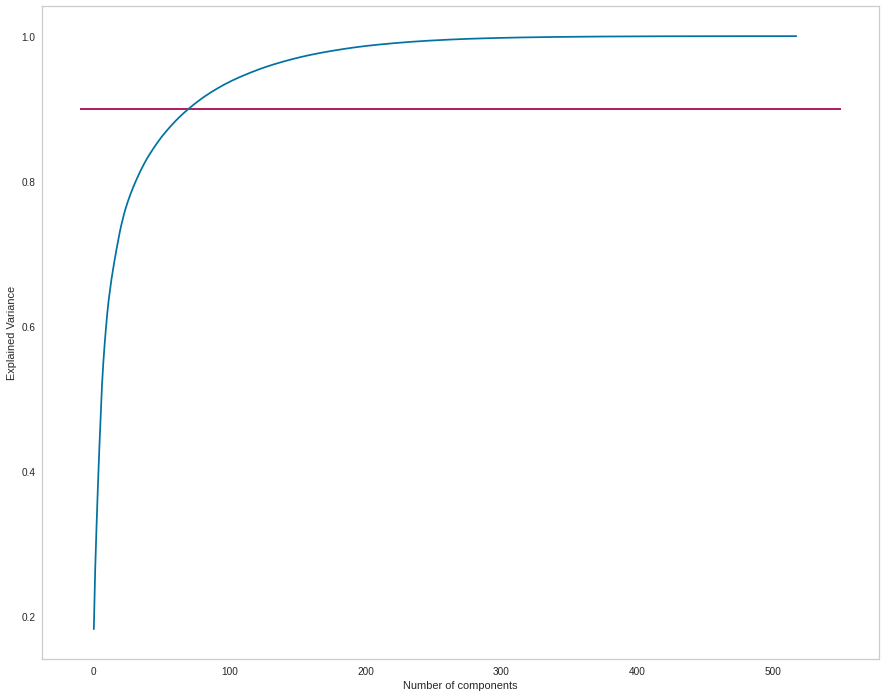

In [ ]:
# plot explained variance ratio to find the number of components explaining 90% of the variance
plot_pca(s_f_features, max=550, col="m")

In [ ]:
# project to 70 dimensions
pca = PCA(n_components = 70)

# fit the PCS
pca_features = pca.fit_transform(s_f_features)

# total explained variance ratio
print(sum(pca.explained_variance_ratio_))

0.8980319870502819


In [ ]:
pca_features_cols = ["PC_Features" + str(i) for i in range(1, 71)]
pca_features = pd.DataFrame(data = pca_features, columns = pca_features_cols)
pca_features.head(5)

,PC_Features1,PC_Features2,PC_Features3,PC_Features4,PC_Features5,PC_Features6,PC_Features7,PC_Features8,PC_Features9,PC_Features10,PC_Features11,PC_Features12,PC_Features13,PC_Features14,PC_Features15,PC_Features16,PC_Features17,PC_Features18,PC_Features19,PC_Features20,PC_Features21,PC_Features22,PC_Features23,PC_Features24,PC_Features25,PC_Features26,PC_Features27,PC_Features28,PC_Features29,PC_Features30,PC_Features31,PC_Features32,PC_Features33,PC_Features34,PC_Features35,PC_Features36,PC_Features37,PC_Features38,PC_Features39,PC_Features40,PC_Features41,PC_Features42,PC_Features43,PC_Features44,PC_Features45,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70
0,0.380064,0.191746,-0.537041,-0.569475,0.615758,-0.587129,0.186706,0.219751,0.220913,-0.052709,-0.164970,-0.049273,0.139353,-0.176116,-0.179367,-0.041632,0.040655,0.064384,0.100597,0.076880,-0.186443,-0.173228,-0.234970,-0.124452,0.072268,0.003437,-0.186037,-0.033473,-0.038747,-0.129628,-0.154568,-0.012453,0.050013,-0.072588,0.126723,0.063518,-0.039556,0.065821,0.047995,-0.086697,0.079237,0.056077,-0.104091,-0.030727,0.025984,0.226308,-0.082034,0.060782,0.037640,0.021543,-0.075106,-0.072888,0.059844,-0.024126,-0.001638,-0.048538,-0.046918,0.064855,-0.049242,-0.047593,0.106707,-0.046191,-0.067511,0.064750,-0.010166,-0.014584,0.010913,-0.060861,-0.016687,0.015929
1,0.653255,-0.151745,-0.716989,0.378775,-0.026112,-0.031138,0.527516,0.002287,-0.087978,0.164042,0.213567,0.139041,0.134833,-0.425022,0.022289,0.008099,0.201675,0.172376,0.155541,0.009518,-0.223738,-0.169823,-0.029586,-0.139560,-0.093092,-0.053191,-0.230178,-0.089497,-0.014472,0.140186,-0.012296,0.041597,0.022698,-0.176628,0.096954,-0.120197,-0.021457,0.016807,0.045400,0.012708,0.111042,-0.034291,-0.046674,-0.149518,-0.008593,0.083182,0.094344,0.027329,-0.028342,-0.043713,0.008666,-0.076073,0.005390,-0.013818,0.024511,0.019820,0.063175,0.009658,-0.018834,0.089394,0.031937,0.015561,-0.051101,-0.035481,-0.035470,0.040376,-0.041117,-0.090564,0.062365,-0.063796
2,0.285410,0.127856,-0.511818,0.076712,0.249607,0.103573,0.152463,0.053156,0.172101,-0.164548,-0.053851,0.013339,-0.062424,-0.068934,-0.264691,-0.023765,0.118082,-0.141040,-0.235147,-0.146860,-0.381688,-0.238725,0.022971,-0.019386,0.082489,-0.143403,-0.224953,0.051441,0.084044,0.161247,-0.143081,-0.158100,-0.154055,-0.043721,0.000019,0.014795,-0.047474,-0.124202,0.095782,-0.013697,0.040230,0.201550,0.191337,-0.012924,-0.032021,0.077176,0.056246,0.025138,-0.004772,0.013663,-0.007519,-0.199727,0.075102,0.001210,0.058986,0.005340,0.096297,-0.005427,0.031559,0.034997,0.002599,-0.042853,-0.048444,0.110386,-0.011397,-0.011882,-0.006306,-0.067232,0.111380,0.000052
3,0.733518,0.384733,-0.450939,0.147021,-0.114900,0.010032,0.428186,-0.037246,-0.339455,-0.199637,0.383193,-0.083709,0.073115,0.049414,-0.304333,0.354455,-0.068157,0.052531,-0.162603,-0.036729,-0.138601,-0.218037,0.061056,0.321772,-0.037667,0.049419,-0.117125,-0.187648,0.114361,0.003554,-0.037144,0.044194,0.072902,0.134985,0.041860,-0.028982,0.027645,-0.067182,0.002648,0.012963,-0.107728,-0.039821,0.058266,-0.102483,-0.182784,-0.057254,-0.065445,0.060980,0.003703,-0.019165,-0.031784,0.058532,0.057328,-0.035760,-0.003347,0.030063,-0.078988,-0.182486,-0.062004,-0.104796,0.128819,-0.147583,0.002887,0.054619,0.001020,0.005610,-0.044023,0.074336,-0.019591,0.039057
4,-0.022270,-0.217946,0.064536,0.489496,0.123674,0.177458,0.004762,0.210294,-0.399921,-0.259109,0.160081,0.377269,-0.320471,-0.065169,0.389996,0.017712,-0.186898,-0.036126,-0.041838,0.130573,0.238765,0.062242,0.114013,-0.140762,0.214050,0.112764,0.062296,-0.069633,0.081951,0.133797,-0.021507,-0.033131,-0.174952,-0.211236,0.151716,-0.041942,0.075495,-0.0274

In [ ]:
# repeat previous steps without considering the echonest dataset
dfs = [s_f_tracks, pca_features]
df_noEchonest = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True,
                                            how='inner'), dfs)

In [ ]:
df_noEchonest.head()

,artist_name,track_duration,track_genre_top,track_genres_all,track_genres,track_language_code,track_genre_id,PC_Features1,PC_Features2,PC_Features3,PC_Features4,PC_Features5,PC_Features6,PC_Features7,PC_Features8,PC_Features9,PC_Features10,PC_Features11,PC_Features12,PC_Features13,PC_Features14,PC_Features15,PC_Features16,PC_Features17,PC_Features18,PC_Features19,PC_Features20,PC_Features21,PC_Features22,PC_Features23,PC_Features24,PC_Features25,PC_Features26,PC_Features27,PC_Features28,PC_Features29,PC_Features30,PC_Features31,PC_Features32,PC_Features33,PC_Features34,PC_Features35,PC_Features36,PC_Features37,PC_Features38,PC_Features39,PC_Features40,PC_Features41,PC_Features42,PC_Features43,PC_Features44,PC_Features45,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70
2,AWOL,168,Hip-Hop,[21],[21],en,21,0.285410,0.127856,-0.511818,0.076712,0.249607,0.103573,0.152463,0.053156,0.172101,-0.164548,-0.053851,0.013339,-0.062424,-0.068934,-0.264691,-0.023765,0.118082,-0.141040,-0.235147,-0.146860,-0.381688,-0.238725,0.022971,-0.019386,0.082489,-0.143403,-0.224953,0.051441,0.084044,0.161247,-0.143081,-0.158100,-0.154055,-0.043721,0.000019,0.014795,-0.047474,-0.124202,0.095782,-0.013697,0.040230,0.201550,0.191337,-0.012924,-0.032021,0.077176,0.056246,0.025138,-0.004772,0.013663,-0.007519,-0.199727,0.075102,0.001210,0.058986,0.005340,0.096297,-0.005427,0.031559,0.034997,0.002599,-0.042853,-0.048444,0.110386,-0.011397,-0.011882,-0.006306,-0.067232,0.111380,0.000052
3,AWOL,237,Hip-Hop,[21],[21],en,21,0.733518,0.384733,-0.450939,0.147021,-0.114900,0.010032,0.428186,-0.037246,-0.339455,-0.199637,0.383193,-0.083709,0.073115,0.049414,-0.304333,0.354455,-0.068157,0.052531,-0.162603,-0.036729,-0.138601,-0.218037,0.061056,0.321772,-0.037667,0.049419,-0.117125,-0.187648,0.114361,0.003554,-0.037144,0.044194,0.072902,0.134985,0.041860,-0.028982,0.027645,-0.067182,0.002648,0.012963,-0.107728,-0.039821,0.058266,-0.102483,-0.182784,-0.057254,-0.065445,0.060980,0.003703,-0.019165,-0.031784,0.058532,0.057328,-0.035760,-0.003347,0.030063,-0.078988,-0.182486,-0.062004,-0.104796,0.128819,-0.147583,0.002887,0.054619,0.001020,0.005610,-0.044023,0.074336,-0.019591,0.039057
5,AWOL,206,Hip-Hop,[21],[21],en,21,-0.237750,-0.294882,0.172745,0.222440,-0.169610,-0.099366,-0.260199,-0.308142,-0.023388,-0.153094,-0.172597,0.066520,-0.109615,-0.370870,-0.052226,-0.035150,-0.122124,0.062219,0.235181,0.009356,-0.043547,-0.160177,0.199048,-0.134099,-0.053650,-0.115808,-0.068980,0.127596,-0.066068,-0.077846,0.165530,-0.113966,-0.090326,0.059191,0.071373,-0.096696,-0.022005,0.082726,0.011409,-0.033507,-0.054030,-0.089988,-0.020767,0.059857,0.054029,-0.012797,-0.044063,-0.011017,0.043936,-0.047707,-0.030057,-0.098548,-0.059141,0.009673,0.038974,-0.065555,0.024586,0.003893,-0.074379,0.063410,-0.037369,0.046460,0.018027,0.049119,-0.037515,0.069399,-0.055275,0.001068,0.019142,-0.005425
10,Kurt Vile,161,Pop,[10],[10],en,10,-0.091778,0.154290,-0.028420,-0.016623,-1.096831,-0.083462,0.345646,0.427235,-0.080976,0.090382,-0.070016,-0.134071,-0.155388,-0.300153,-0.021593,0.045550,-0.133978,0.171619,-0.052253,-0.108404,-0.215883,0.055138,-0.274267,-0.009664,0.196900,0.112359,-0.004450,-0.144946,0.124203,-0.018442,-0.116008,-0.027598,0.068352,-0.080590,-0.117241,-0.020231,0.193753,-0.084089,-0.198652,-0.137476,0.045693,0.037673,0.109176,-0.000922,0.015954,-0.057588,-0.071456,-0.096300,0.048420,0.044006,-0.051725,0.007645,-0.004535,-0.064319,-0.026786,0.096523,-0.074773,0.065052,-0.051414,-0.008112,0.019628,0.066412,0.035434,0.025869,-0.013674,0.015905,0.049773,-0.018057,0.027775,0.017719
20,Nicky Cook,311,Pop,"[17, 10, 76, 103]","[76, 103]",en,76,-0.546482,-0.028081,-0.370790,0.320190,0.0800

Our new dataset (without echonest) is made up of 80 columns and 106574 rows. 

In [ ]:
df_noEchonest.shape

(106574, 77)

# Optimal number of clusters

In [ ]:
# remove categorical columns
df_noEchonest = no_categorical(df_noEchonest)

In [ ]:
df_noEchonest.columns

Index(['track_duration', 'track_language_code', 'PC_Features1', 'PC_Features2',
       'PC_Features3', 'PC_Features4', 'PC_Features5', 'PC_Features6',
       'PC_Features7', 'PC_Features8', 'PC_Features9', 'PC_Features10',
       'PC_Features11', 'PC_Features12', 'PC_Features13', 'PC_Features14',
       'PC_Features15', 'PC_Features16', 'PC_Features17', 'PC_Features18',
       'PC_Features19', 'PC_Features20', 'PC_Features21', 'PC_Features22',
       'PC_Features23', 'PC_Features24', 'PC_Features25', 'PC_Features26',
       'PC_Features27', 'PC_Features28', 'PC_Features29', 'PC_Features30',
       'PC_Features31', 'PC_Features32', 'PC_Features33', 'PC_Features34',
       'PC_Features35', 'PC_Features36', 'PC_Features37', 'PC_Features38',
       'PC_Features39', 'PC_Features40', 'PC_Features41', 'PC_Features42',
       'PC_Features43', 'PC_Features44', 'PC_Features45', 'PC_Features46',
       'PC_Features47', 'PC_Features48', 'PC_Features49', 'PC_Features50',
       'PC_Features51', 'PC

In [ ]:
# We will store the sum of distortions for each number of clusters
Distortion_list = []

# We will store the Sillhuoette score for each number of clusters
Silhuoette_list = []

# We will set her for how many clusters we want to check 
Number_of_Test = 10

# Trying different number of clusters
for k in range(2, Number_of_Test + 1):
    Centroids, Clusters = kmeans(df_noEchonest.values, k)
  
    # WCSS (Within cluster sum of square)
    Distortion_Value = Distortion(df_noEchonest.values, Centroids, Clusters)
    Distortion_list.append(Distortion_Value)
    
    # Computing the Silhuoette score
    #Silhuoette_coefficient = Silhouette(df_merged.values, Clusters)
    # Silhuoette_list.append(Silhuoette_coefficient)

## Showing the result

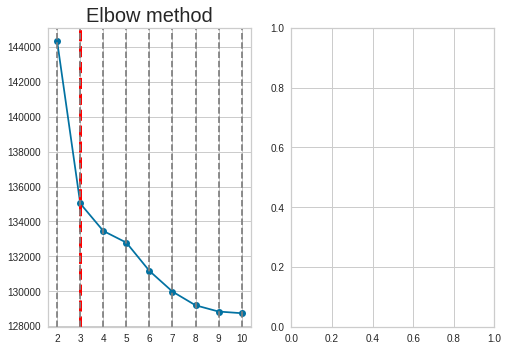

In [ ]:
# We need two subplots
fig, ax = plt.subplots(1, 2)

# Taking the values for the x and y axis
x_axis = list(map(str, list(range(2, Number_of_Test + 1))))

# Plot the elbow method's values
ax[0].plot(x_axis , Distortion_list, marker = 'o')

# Plot the silhuoette score value's
#ax[1].plot(x_axis, Silhuoette_list, marker = 'o')
    
    
# Pick the elbow point in elbow method 
kn = KneeLocator(range(2, Number_of_Test + 1), Distortion_list, curve='convex', direction='decreasing')

# Show the best value for the cluster with different number 
ax[0].axvline(kn.knee - 2, linestyle = 'dashed', color = 'red', linewidth = 3)

# Show the least precision 
#ax[1].axhline(y = .70, linestyle = 'dashed', color = 'red', linewidth = 3)
# We put vertical lines to better identify the points
for xv in x_axis:
    ax[0].axvline(x=xv, color='gray', linestyle='--')
    #ax[1].axvline(x=xv, color='gray', linestyle='--')
    
ax[0].set_title('Elbow method', fontsize = 20)
#ax[1].set_title('Silhuoette score', fontsize = 20)
plt.show()

Using scikit-learn

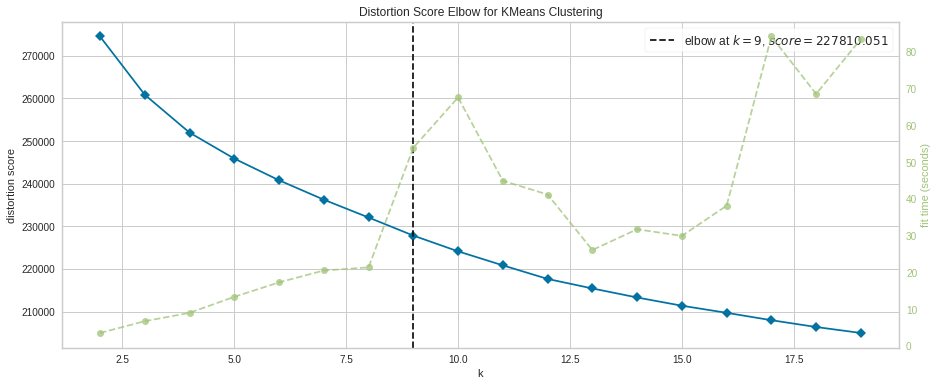

In [ ]:
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(df_noEchonest) # Fit the data to the visualizer
visualizer.show();  # Finalize and render the figure

# Applying the KMeans

applying our version of the k-means

In [ ]:
# The default value for the number of clusters will be the one picked by the elbow method
number_of_clusters = 9

# We will take the results
Centroids , Clusters = kmeans(df_noEchonest.values, number_of_clusters)

In [ ]:
# Dataframe with "Cluster" column
df_noEchonest.insert(0, "cluster", Clusters)
df_noEchonest.head()

,cluster,track_duration,track_language_code,PC_Features1,PC_Features2,PC_Features3,PC_Features4,PC_Features5,PC_Features6,PC_Features7,PC_Features8,PC_Features9,PC_Features10,PC_Features11,PC_Features12,PC_Features13,PC_Features14,PC_Features15,PC_Features16,PC_Features17,PC_Features18,PC_Features19,PC_Features20,PC_Features21,PC_Features22,PC_Features23,PC_Features24,PC_Features25,PC_Features26,PC_Features27,PC_Features28,PC_Features29,PC_Features30,PC_Features31,PC_Features32,PC_Features33,PC_Features34,PC_Features35,PC_Features36,PC_Features37,PC_Features38,PC_Features39,PC_Features40,PC_Features41,PC_Features42,PC_Features43,PC_Features44,PC_Features45,PC_Features46,PC_Features47,PC_Features48,PC_Features49,PC_Features50,PC_Features51,PC_Features52,PC_Features53,PC_Features54,PC_Features55,PC_Features56,PC_Features57,PC_Features58,PC_Features59,PC_Features60,PC_Features61,PC_Features62,PC_Features63,PC_Features64,PC_Features65,PC_Features66,PC_Features67,PC_Features68,PC_Features69,PC_Features70
0,7,0.009155,0.204545,0.380064,0.191746,-0.537041,-0.569475,0.615758,-0.587129,0.186706,0.219752,0.220913,-0.052708,-0.164972,-0.049274,0.139346,-0.176113,-0.179358,-0.041664,0.040645,0.064371,0.100594,0.076861,-0.186475,-0.173292,-0.234926,-0.124448,0.072168,0.003455,-0.186076,-0.033991,-0.038068,-0.129355,-0.154435,-0.012563,0.050367,-0.072751,0.126615,0.062567,-0.039188,0.065122,0.047086,-0.088666,0.081158,0.061726,-0.097194,-0.033296,0.014113,0.224400,-0.082545,0.064477,0.038799,0.025002,-0.071916,-0.068539,0.056911,-0.028786,-0.034658,-0.003758,-0.064306,-0.071560,-0.033855,0.036363,0.069685,0.046666,-0.085512,0.040772,0.031117,0.046869,-0.031939,0.040739,-0.048417,-0.023480
1,0,0.012916,0.204545,0.653255,-0.151745,-0.716989,0.378775,-0.026112,-0.031138,0.527516,0.002287,-0.087978,0.164041,0.213567,0.139038,0.134834,-0.425027,0.022308,0.008113,0.201651,0.172382,0.155593,0.009514,-0.223766,-0.169750,-0.029635,-0.139608,-0.092890,-0.053217,-0.230147,-0.089885,-0.014549,0.139638,-0.012910,0.041403,0.023101,-0.174712,0.096091,-0.120372,-0.021256,0.019784,0.046468,0.011374,0.113819,-0.036491,-0.045641,-0.141228,-0.016439,0.091023,0.102002,0.024986,-0.035067,-0.039418,0.003042,-0.088864,0.007414,-0.018871,0.023229,-0.010931,0.053225,-0.039507,0.029665,-0.079829,-0.016383,0.066661,-0.033984,0.009598,-0.038879,-0.003209,0.008226,0.010752,0.146986,-0.092324
2,4,0.011226,0.204545,0.285410,0.127856,-0.511818,0.076712,0.249606,0.103573,0.152463,0.053156,0.172102,-0.164547,-0.053849,0.013345,-0.062419,-0.068919,-0.264697,-0.023724,0.118110,-0.141017,-0.235171,-0.146919,-0.381663,-0.238807,0.022773,-0.019450,0.082901,-0.143637,-0.224536,0.051828,0.084501,0.161011,-0.141987,-0.157458,-0.154550,-0.043538,-0.000320,0.017953,-0.050674,-0.121677,0.093583,-0.014669,0.036273,0.195276,0.187132,-0.008544,-0.021843,0.085622,0.045257,0.040105,0.008960,0.018174,-0.009850,-0.186828,0.104246,0.009873,0.040060,-0.050753,0.107146,-0.002534,0.097301,0.009212,0.063122,-0.018333,-0.002503,0.087126,0.053580,0.063998,-0.034405,0.105694,0.054439,-0.019835
3,4,0.008774,0.204545,0.733518,0.384733,-0.450939,0.147021,-0.114900,0.010032,0.428186,-0.037247,-0.339455,-0.199636,0.383193,-0.083706,0.073120,0.049412,-0.304321,0.354464,-0.068108,0.052516,-0.162597,-0.036604,-0.138461,-0.218031,0.061179,0.321870,-0.037717,0.049192,-0.117605,-0.187597,0.114922,0.003046,-0.038136,0.041890,0.071812,0.134099,0.043386,-0.028320,0.029360,-0.065065,0.003932,0.012800,-0.110950,-0.045568,0.057569,-0.103020,-0.177547,-0.065471,-0.053384,0.055606,0.002890,-0.026547,-0.026595,0.067131,0.046133,-0.042722,0.000680,-0.009873,-0.064539,0.147707,-0.132179,0.048639,0.246624,-0.012855,-0.042198,0.107073,-0.012010,0.009001,0.070586,-0.073975,-0.046321,-0.106590
4,5,0.016948,0.204545,-0.022270,-0.217946,0.064536,0.489496,0.123674,0.177458,0.004762,0.210294,-0.399921,-0.259108,0.160077,0.377267,-0.320476,-0.065180,0.390005,0.017727,-0.186958,-0.036103,-0.041751,0.130558,0.238694,0.062238,0.11401

# Visualizing the results

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15.7, 10.27


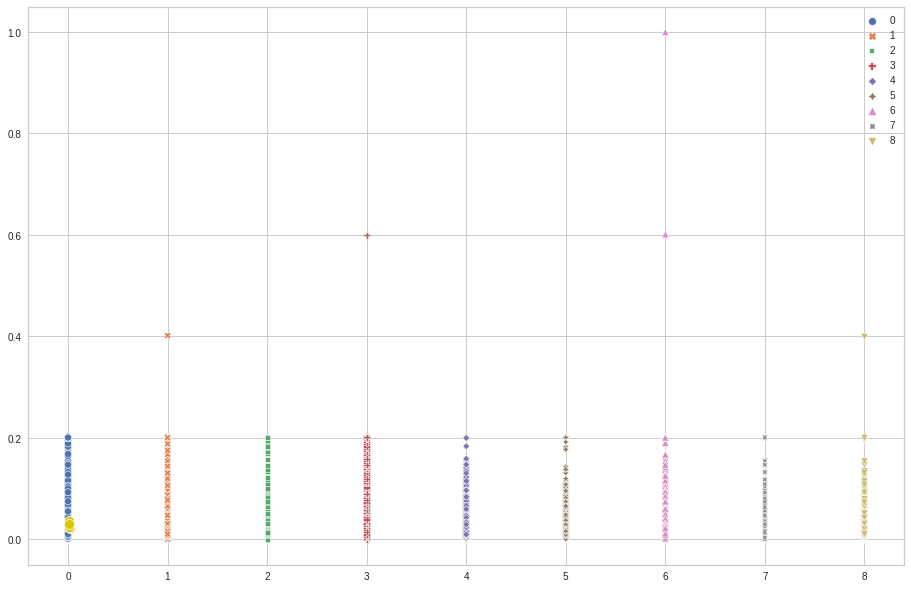

In [ ]:
# Group the datapoints that share the same cluster
sns.scatterplot(x = df_noEchonest.values[:,0], y = df_noEchonest.values[:, 1], hue = Clusters, style = Clusters, palette="deep")

# Show the center of the clusters
sns.scatterplot(x = Centroids[:,0], y = Centroids[:, 1], s= 100, color='y')

plt.show();

# **2.4: Analysing your results!**

To determine the genre of a song, we identify as most useful the following columns: 


*   From the **features** dataset:

1. chroma_cens_mean_01 
2. chroma_cqt_mean_01
3. chroma_stft_mean_01 
(1., 2., and 3. are used in thi study for audio-based chord recognition: https://iopscience.iop.org/article/10.1088/1742-6596/1802/3/032033)
4. mfcc_mean_01 (MFCC has proven to be one of the most successful spectrum features in speech and music related recognition tasks --> https://www.sciencedirect.com/science/article/pii/S1110866515000419)
5. zcr_mean_01
6. rmse_mean_01

*   From the **tracks** dataset:

7.   track_duration
8.   track_language_code


In [ ]:
# create new dataframe
df = pd.DataFrame()

# insert the chosen columns from the echonest dataset
# they are the first 7 columns of the dataset
df.insert(0, "chroma_cens_mean_01", features["chroma_cens_mean_01"])
df.insert(1, "chroma_cqt_mean_01", features["chroma_cqt_mean_01"])
df.insert(2, "chroma_stft_mean_01", features["chroma_stft_mean_01"])
df.insert(3, "mfcc_mean_01", features["mfcc_mean_01"])
df.insert(4, "zcr_mean_01", features["zcr_mean_01"])
df.insert(5, "rmse_mean_01", features["rmse_mean_01"])


# insert the two columns from tracks
df.insert(6, "track_duration", tracks["track_duration"])
df.insert(7, "track_language_code", tracks["track_language_code"])

# reset index to match (the order of the rows doesn't change)
df = df.reset_index(drop=True)
# insert clusters
df.insert(8, "cluster", df_noEchonest["cluster"])



In [ ]:
df.head()

,chroma_cens_mean_01,chroma_cqt_mean_01,chroma_stft_mean_01,mfcc_mean_01,zcr_mean_01,rmse_mean_01,track_duration,track_language_code,cluster
0,0.474300,0.883210,0.696063,-163.772964,0.085629,3.188761,206.0,en,7
1,0.232784,0.525373,0.449602,-159.004166,0.084578,3.607359,161.0,en,0
2,0.258420,0.535632,0.481160,-205.440491,0.053114,3.251386,181.0,en,4
3,0.229882,0.519918,0.388109,-135.864822,0.077515,3.893810,837.0,en,4
4,0.202806,0.443509,0.346976,-135.135895,0.047225,4.600440,354.0,en,5


In [ ]:
# Divide numerical columns into 4 categories
labels=['Low', 'Medium', 'High', 'Great']

for col in range(7):
    df[list(df.columns)[col]] = pd.qcut(df[list(df.columns)[col]], [0, .25, .5, .75, 1.], labels=labels)

In [ ]:
df.head()

,chroma_cens_mean_01,chroma_cqt_mean_01,chroma_stft_mean_01,mfcc_mean_01,zcr_mean_01,rmse_mean_01,track_duration,track_language_code,cluster
0,Great,Great,Great,High,Great,Medium,Medium,en,7
1,Medium,High,Medium,High,Great,Medium,Medium,en,0
2,High,High,High,Medium,High,Medium,Medium,en,4
3,Medium,High,Medium,Great,Great,Medium,Great,en,4
4,Low,Medium,Low,Great,High,High,Great,en,5


# **PIVOTS**

To create each pivot table, we first select the variable of interest and the cluster column. Then, we make use of the pivot_table function from pandas, selecting as *index* the variable we selected earlier (one at a time) and as *columns* the cluster feature. Lastly, we compute the percentage for each column.



---
chroma_cens_mean_01

---




In [ ]:
# pivot for chroma_cens_mean_01
pivot1_cols = ['chroma_cens_mean_01', 'cluster']

pivot1 = df[pivot1_cols]

pivot1 = pd.pivot_table(data=pivot1, 
                        index='chroma_cens_mean_01', 
                        columns='cluster', 
                        aggfunc=len)

pivot1 = round(pivot1 / pivot1.sum() * 100, 2)

pivot1

cluster,0,1,2,3,4,5,6,7,8
chroma_cens_mean_01,,,,,,,,,
Low,14.50,35.64,56.10,15.60,14.59,59.38,41.86,0.33,9.08
Medium,24.53,27.52,21.82,29.16,30.64,24.30,25.24,0.72,21.25
High,29.26,21.43,13.44,33.28,33.38,11.88,18.20,4.16,31.32
Great,31.71,15.41,8.64,21.96,21.39,4.44,14.70,94.78,38.35


“Chroma Energy Normalized Statistics” (CENS) are often used for tasks related to audio matching and similarity as they smooth out local deviations in tempo, articulation,(e.g., trills vibratos). It appears from our pivot table that cluster 7 mostly consists of songs with **Great** *chroma_cens_mean_01*. Also clusters 2 and 5 have a majority of instances with **Low** cens.



---
chroma_cqt_mean_01

---




In [ ]:
# pivot for chroma_cqt_mean_01
pivot2_cols = ['chroma_cqt_mean_01', 'cluster']

pivot2 = df[pivot2_cols]

pivot2 = pd.pivot_table(data=pivot2, 
                        index='chroma_cqt_mean_01', 
                        columns='cluster', 
                        aggfunc=len)

pivot2 = round(pivot2 / pivot2.sum() * 100, 2)

pivot2

cluster,0,1,2,3,4,5,6,7,8
chroma_cqt_mean_01,,,,,,,,,
Low,9.01,50.57,55.38,14.55,8.11,59.76,48.46,1.25,4.59
Medium,22.61,29.23,26.97,33.36,25.88,28.08,29.26,5.50,11.06
High,31.88,15.30,12.67,35.13,37.73,10.33,15.48,13.52,23.83
Great,36.51,4.90,4.99,16.95,28.28,1.83,6.81,79.73,60.53


The chroma_cqt_mean_01 clusters are in a line with what we found in pivot 1: cluster 7 mostly consists of songs with **Great** chroma_cqt_mean_01, while cluster 2 and 5 mainly involve instances with **Low** cqt.



---
chroma_stft_mean_01

---




In [ ]:
# pivot for chroma_stft_mean_01
pivot3_cols = ['chroma_stft_mean_01', 'cluster']

pivot3 = df[pivot3_cols]

pivot3 = pd.pivot_table(data=pivot3, 
                        index='chroma_stft_mean_01', 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot3 = round(pivot3 / pivot3.sum() * 100, 2)

pivot3

cluster,0,1,2,3,4,5,6,7,8
chroma_stft_mean_01,,,,,,,,,
Low,0.65,66.72,44.78,26.44,26.65,41.52,11.32,4.09,3.84
Medium,9.48,21.63,28.60,38.22,36.87,28.41,24.78,10.33,13.32
High,34.31,9.16,17.21,26.82,26.84,18.96,32.03,20.59,29.46
Great,55.56,2.49,9.41,8.52,9.65,11.12,31.88,65.00,53.37


chroma_stft_mean_01 features are distributed a bit differently from the two chroma feature we just analyzed, with clusters 0, 7 and 8 containing predominantly songs with **Great** stft and cluster 1 and 2 songs with **Low** stft.Again, songs with **Medium** and **High** stft contribute "almost" the same to all clusters (with a peak in the 3rd cluster and a fall in the 0th for **Medium** and a peak in the 0th and a fall in the 1st for **High**)



---
mfcc_mean_01

---




In [ ]:
# pivot for mfcc_mean_01
pivot4_cols = ['mfcc_mean_01', 'cluster']

pivot4 = df[pivot4_cols]

pivot4 = pd.pivot_table(data=pivot4, 
                        index='mfcc_mean_01', 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot4 = round(pivot4 / pivot4.sum() * 100, 2)

pivot4

cluster,0,1,2,3,4,5,6,7,8
mfcc_mean_01,,,,,,,,,
Low,8.36,68.50,28.38,23.16,13.74,25.65,21.60,36.16,13.50
Medium,18.77,24.32,31.21,31.27,22.83,31.39,28.34,30.91,13.70
High,30.69,6.08,24.31,29.30,30.16,26.22,29.65,21.13,20.80
Great,42.18,1.11,16.10,16.27,33.27,16.74,20.41,11.79,52.01


MFCCs are used in music genre classification to detect timbre (Jensen et al., 2006). From our pivot table, we observe that now cluster 7 has as its smallest contributor songs with **Great** mfcc (oppositily from what we discovered earlier). Other clusters, instead, mantain the same structure they had with the chroma features. For example, cluster 0 and 1 always have as their less significant components songs with **Low** and **Great** mfcc (/chroma), respectively.



---
zcr_mean_01

---




In [ ]:
# pivot for zcr_mean_01
pivot5_cols = ['zcr_mean_01', 'cluster']

pivot5 = df[pivot5_cols]

pivot5 = pd.pivot_table(data=pivot5, 
                        index='zcr_mean_01', 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot5 = round(pivot5 / pivot5.sum() * 100, 2)

pivot5

cluster,0,1,2,3,4,5,6,7,8
zcr_mean_01,,,,,,,,,
Low,10.64,44.07,38.76,10.02,12.46,38.35,42.98,46.11,18.28
Medium,17.65,29.15,30.39,27.38,24.06,30.73,29.33,27.04,15.06
High,27.37,16.04,19.88,32.07,33.96,20.82,19.01,16.69,22.93
Great,44.35,10.75,10.97,30.53,29.52,10.10,8.69,10.17,43.74


ZCR (Zero Crossing Rates) are extensively used in speech recognition and music information retrieval, as they are a key feature for the classification of percussive sounds. What we notice in the pivot table is that all our 9 clusters are pretty much composed of the 4 categories without any dominant contribution from one class (we see, in fact, that we have no value over 50%).



---
rmse_mean_01

---




In [ ]:
# pivot for rmse_mean_01
pivot6_cols = ['rmse_mean_01', 'cluster']

pivot6 = df[pivot6_cols]

pivot6 = pd.pivot_table(data=pivot6, 
                        index='rmse_mean_01', 
                        columns='cluster',  
                        aggfunc=len, fill_value=0)

pivot6 = round(pivot6 / pivot6.sum() * 100, 2)

pivot6

cluster,0,1,2,3,4,5,6,7,8
rmse_mean_01,,,,,,,,,
Low,10.46,53.62,25.20,27.80,24.66,23.17,13.31,28.00,19.23
Medium,17.44,27.30,27.30,25.88,29.06,29.34,22.87,29.01,19.80
High,29.37,14.11,25.45,27.29,24.95,26.07,30.60,23.32,22.51
Great,42.74,4.97,22.05,19.03,21.33,21.42,33.22,19.67,38.46


The pivot table between the RMSE (Root Mean Square Error) and the clusters shows that - apart from cluster 1 (which has the smallest input from songs with Great rmse and the biggest from songs with low rmse), the rest if the clusters do not exhibit any particular characteristic.



---
track_duration

---




In [ ]:
# pivot for track_duration
pivot7_cols = ['track_duration', 'cluster']

pivot7 = df[pivot7_cols]

pivot7 = pd.pivot_table(data=pivot7, 
                        index='track_duration', 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot7 = round(pivot7 / pivot7.sum() * 100, 2)

pivot7

cluster,0,1,2,3,4,5,6,7,8
track_duration,,,,,,,,,
Low,25.00,24.85,24.96,25.16,26.27,25.25,24.61,24.25,24.38
Medium,25.32,24.73,25.51,24.90,24.52,25.21,24.53,26.42,25.63
High,25.41,26.02,25.21,24.84,24.24,24.16,25.54,24.82,24.87
Great,24.27,24.39,24.31,25.10,24.98,25.39,25.32,24.51,25.13


All values are toughly around 25. That is, the clusters do not take into account the duration of the song



---
track_language_code

---




In [ ]:
# pivot for track_language_code
pivot8_cols = ['track_language_code', 'cluster']

pivot8 = df[pivot8_cols]

pivot8 = pd.pivot_table(data=pivot8, 
                        index='track_language_code', 
                        columns='cluster', 
                        aggfunc=len, fill_value=0)

pivot8 = round(pivot8 / pivot8.sum() * 100, 2)

pivot8

cluster,0,1,2,3,4,5,6,7,8
track_language_code,,,,,,,,,
,89.75,88.15,87.13,88.28,83.62,87.15,89.83,88.16,84.34
ar,0.01,0.00,0.00,0.01,0.03,0.02,0.00,0.00,0.00
bg,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
bm,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
cs,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
de,0.03,0.04,0.09,0.07,0.07,0.08,0.03,0.00,0.00
ee,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.04
el,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.03,0.00
en,9.53,11.20,12.48,11.10,15.57,12.25,9.60,11.18,14.94


As we already discovered earlier, the language of the song is not a very useful feature in our task, mostly because the majority of values turn out to be zero or have no language associated (that's because during the pre-processing we imputed the missing values we had with an empty string). Apart from these important issues, we see that English is the predominant language in our clusters, followed by Spanish, Portuguese, Russian, French, German and Italian.



---
Genres


---



Lastly, we look at which are the most representative genres for each cluster.

In [ ]:
# add the genre column to the dataframe
df.insert(9, "genre", tracks["track_genre_top"])

In [ ]:
# create pivot table with the genres and the clusters
pivot_genre_cols = ['genre', 'cluster']

pivot_genre = df[pivot_genre_cols]

pivot_genre = pd.pivot_table(data = pivot_genre, 
                        index = 'genre', 
                        columns = 'cluster', 
                        aggfunc=len, fill_value=0)

pivot_genre = round(pivot_genre / pivot_genre.sum() * 100, 2)

pivot_genre

cluster,0,1,2,3,4,5,6,7,8
genre,,,,,,,,,
,1.91,2.19,2.04,2.80,2.06,2.05,1.94,1.94,1.56
Blues,0.52,2.05,2.05,1.20,1.64,4.29,1.31,2.47,0.38
Classical,0.15,10.68,1.17,0.77,0.65,1.61,0.95,1.41,0.22
Country,0.16,0.67,1.26,0.66,0.88,1.47,0.67,0.46,0.28
Easy Listening,0.11,0.14,0.20,0.27,0.07,0.15,0.23,0.39,0.06
Electronic,42.52,13.80,20.64,25.68,13.24,16.92,27.07,25.66,24.94
Experimental,16.51,25.27,20.16,23.57,21.27,16.78,15.97,23.37,29.13
Folk,0.78,10.47,11.24,4.09,4.65,12.10,4.91,7.35,1.33
Hip-Hop,9.99,0.50,3.53,5.63,3.12,2.27,5.03,2.87,2.34


Similarly to what we had with Echonest, we see again that all clusters contain for the most part rock, experimental and electronic songs, which makes sense since they are predominant in our dataset. In particular, cluster 1, 3, and 6 mostly accomodate electronic songs, while cluster 4 and 8 primarily consist of rock songs.

**If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses?**

If we could choose, we would choose more observations with fewer features since - as we saw with the PCA - some variables are redundant and they do not add anything in terms of explained variability.

# 2.Bouns K-Means using MapReduce

Here we are asked to implement the K-means using MapReduce. 

As we were just asked to implement it, here we use a sample dataset in order to apply the algorithm on. 

In [40]:
import numpy as np 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Here we will read one example dataset. 

In [13]:
DataFrame = spark.read.csv('s3://myadmhomework4/clustering.csv', header=True)
DataFrame.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: string (nullable = true)
 |-- CoapplicantIncome: string (nullable = true)
 |-- LoanAmount: string (nullable = true)
 |-- Loan_Amount_Term: string (nullable = true)
 |-- Credit_History: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

Take a look at what do we have in our dataset. 

In [14]:
DataFrame.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|     128.0|           360.0|           1.0|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|      66.0|           360.0|           1.0|        Urban|          Y|
|LP001006|  Male|    Yes|         0|Not Graduate|           No|           2583|           2358.0|     120.0|           360.0|           1.0|        Urban|          Y

We will filter the two columns that we want to apply the algorithm on. 

In [15]:
Partial_data_frame = DataFrame.select('ApplicantIncome', 'LoanAmount')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2.Bouns.1 Functions for using in MapReduce

We defined two functions that will be used when we want to perform our map and reduce functions. 

In [16]:
# Choose the centroid that has the minimum distance with this sample
def PickCluster(Data, Centroids):
    
    Chosen_cluster, Minimum_distance = 0, float('inf')
    for cluster in Centroids:
        Distance_value = 0 
        for data_index in range(len(Data)):
            Distance_value += (Data[data_index] - cluster[1][data_index])**2
        
        Distance_value = Distance_value ** .5    
        if Distance_value < Minimum_distance:
            Minimum_distance = Distance_value
            Chosen_cluster = cluster[0]
    return (Chosen_cluster, [Data])

# To compute the mean of the points assigend to each cluster
def CentroidsMean(Centroid_and_points):
    
    DataPoints = Centroid_and_points[1]
    # Numpy array for computing the sum of the points 
    Sum_points = np.zeros(len(DataPoints[0]))
    for datapoint in DataPoints:
        Point_array = np.array(datapoint)
        Sum_points += datapoint
    Mean_points = Sum_points/len(DataPoints)
    return (Centroid_and_points[0], tuple(Mean_points))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2.Bouns.2 Main function 

Here you can see the implementation of KMeans algorithm using MapReduce. 

In [42]:
# The implementation of Kmeans algorithm using MapReduce
def Kmeans(Samples, Number_of_clusters):

    # Take random centroids 
    Centroids = Samples.takeSample(withReplacement = False , num = Number_of_clusters)


    # Give each centroid the index of the cluster
    #(cluster, (centroid_x, centroid_y))
    Centroids = list(enumerate(Centroids))
    
    # The results will be stored here
    Result = None
    
    # Until convergence
    while True:
        
        # Give each sample the label of the closest cluster
        # (cluster, (sample_x, sample_y))
        Clustered_datapoints  = Samples.map(lambda x: PickCluster(x, Centroids))

        # Here we will take all the samples that were given to each of the clusters
        # (cluster, [list of the points given to this cluster])
        Centroids_points_rdd = Clustered_datapoints.reduceByKey(lambda x, y: x + y )

        # Update the mean of each cluster
        # (cluster, (centroid_x, centroid_y))
        New_centroids = Centroids_points_rdd.map(lambda x: CentroidsMean(x))
        
        # If our centroids changed
        if Centroids == New_centroids.collect():
            
            # Take the clusters given to each datapoint
            Result = Clustered_datapoints.collect()
            
            # Return the clusters of each datapoint and also the mean of each cluster
            return Result, Centroids
        # Update the new mean of each cluster
        Centroids = New_centroids.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2.Bouns.3 Running the K-means

In [43]:
# Take the columns values that we wanted
Desired_data = Partial_data_frame.rdd

# We convert our values from string to float 
Samples = Desired_data.map(lambda x: (float(x[0]), float(x[1])))

# Running our K-means by passing the data and the number of the clusters 
Samples_clustered, Centroids = Kmeans(Samples, 3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2.Bouns.4 Results

* **Note**: As we are working on EMR, there are lots of dificulties in order to show the results in charts. We tried different approaches in order to add seaborn or matplotlib packages but we failed. 

Here we will show the clusters for the first 10 samples. 

In [50]:
print("Check the cluster for each point: \n\n")
print("Format ---> (Cluster, (x_point, y_point))\n")
print(*Samples_clustered[:10], sep = '\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Check the cluster for each point: 


Format ---> (Cluster, (x_point, y_point))

(0, [(4583.0, 128.0)])
(2, [(3000.0, 66.0)])
(2, [(2583.0, 120.0)])
(1, [(6000.0, 141.0)])
(2, [(2333.0, 95.0)])
(2, [(3200.0, 70.0)])
(2, [(2500.0, 109.0)])
(2, [(1853.0, 114.0)])
(2, [(1299.0, 17.0)])
(0, [(4950.0, 125.0)])

* **Note:** If we were able to install seaborn on EMR, by running this cell we will be able to run plot our data. 

In [51]:
Cluster_index_of_points, points_x, points_y = [x[0] for x in Samples_clustered],\
                                              [x[1][0][0] for x in Samples_clustered],\
                                              [x[1][0][1] for x in Samples_clustered]
# Group the datapoints that share the same cluster
sns.scatterplot(x = points_x, y = points_y, hue = Cluster_index_of_points, style = Cluster_index_of_points, palette="deep")


Centroid_x, Centroid_y = [x[0] for x in Centroids], [x[1] for x in Centroids]
# Show the center of the clusters
sns.scatterplot(x = Centroid_x, y = Centroid_y, s= 100, color='y')

plt.xlabel('Income')
plt.ylabel('Loan')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'sns' is not defined
Traceback (most recent call last):
NameError: name 'sns' is not defined



# 3. Algorithmic questions 

In [2]:
# This function given a list will return the pairs that their sum is equal to x
def Pairs(List, x): 
    return [i for i in combinations(List, 2) if sum(i) == x]

A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
X = 4
print("The pairs that their sum is equal to \'"+str(X)+'\' are: ', end = '')
print(*Pairs(A, X))

The pairs that their sum is equal to '4' are: (7, -3) (-2, 6) (2, 2) (1, 3)
